# TFG Tomás Camero

En este fichero de investigacíon, se pretende trabajar y experimentación con modelos de aprendizaje automáticos cuánticos, a la vez que se compara con los clásicos. Para ello, se ha realizado una clasificación multiclase de tres números del conjunto de datos MNIST, del cual se han elegido el 3, 4 y 5. El motivo de esta eleccion de solo tres números no es mas que debido a los tiempos de entrenamiento y la poca experiencia en este sector. A continuación se presenta un indice con cada modelo.

Para probar cada modelo, antes de redirigirse con el índice, es necesario ejecutar los imports globales y las variables globales. Después de eso, solo es ejecutar paso a paso cada modelo, desde el inicio hasta el final.

El apartado de TFQ es algo diferente a los demas. Debido a los tiempos de entrenamiento de TFQ, se ha podido hacer varias pruebas de modelos, hechos a lo largo de la experimentación. Los modelos del 1 al 4 están simplificados, siendo el v5 el último probado, especificando los pasos en él. El modelo v1 es una extensión del tutorial de TFQ, mejorado para esta investigación. Los demas modelos (v2 a v5) son creados desde cero. Debido a los tiempos de Qiskit, solo se muestra una de las experimentaciones.

IMPORTANTE: Debido a diferencias entre Qiskit y TensorFlow Quantum en los imports, es posible que si ejecutas Qiskit primero y luego intentas ejecutar TFQ, de problemas. Para solucionar esto, solo tienes que volver a ejecutar los imports globales y ejecutar TFQ de nuevo. 

* [MLP](#MLP)
    * [Inicialización de variables](#Inicialización)
    * [Búsqueda de hiperparámetros](#Búsqueda)
    * [Entrenamiento](#Entrenamiento)
    * [Resultados](#Resultados)
    * [Algunas gráficas](#Gráficas)
* [Keras](#Keras)
    * [Inicialización de variables](#Inicialización2)
    * [Creación del modelo](#Modelo2)
    * [Entrenamiento](#Entrenamiento2)
    * [Resultados](#Resultados2)
* [TensorFlow Quantum](#TensorFlow)
    * [Modelo v1 Carga y entrenamiento](#v1inicio)
    * [Modelo v1 resultados](#v1resultados)
    * [Carga de datos común modelos v2,v3,v4 y v5](#cargadatostfq)
    * [Modelo v2 entrenamiento](#v2inicio)
    * [Modelo v2 resultados](#v2resultados)
    * [Modelo v3 entrenamiento](#v3inicio)
    * [Modelo v3 resultados](#v3resultados)
    * [Modelo v4 entrenamiento](#v4inicio)
    * [Modelo v4 resultados](#v4resultados)    
    * [Inicialización de variables modelo v5](#Inicialización3)
    * [Clases](#Clases)
    * [Creación del modelo híbrido](#Modelo3)
    * [Entrenamiento](#Entrenamiento3)
    * [Resultados](#Resultados3)
* [Qiskit](#qiskit)
    * [Inicialización de variables](#Inicialización4)
    * [Funciones necesarias](#Funciones4)
    * [Creación de la red híbrido](#Modelo4)
    * [Entrenamiento](#Entrenamiento4)
    * [Resultados](#Resultados4)
* [Comparaciones](#comparaciones)

# Imports Globales

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import multiprocessing as mp
from matplotlib.patches import Wedge, Circle
%matplotlib inline
import numpy as np
import pandas as pd 
import time as time
import seaborn
import cProfile
from io import StringIO
import pstats
import psutil
import threading
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
import os
import random
from keras.datasets import mnist
from sklearn import metrics
from skimage.transform import resize
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import collections

# Variables Globales

In [4]:
cores = psutil.cpu_count()
init_notebook_mode(connected=True)
random_seed = 122230
#random_seed = random.randint(1,1000000)
#print(random_seed)
os.environ['PYTHONHASHSEED'] = str(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)
num_epochs = 20 
batch_size = 16 
num_classes = 3

# MLP<a class="anchor" id="MLP"></a>

In [72]:
from sklearn import datasets, metrics
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPClassifier

## 1. Inicialización de variables <a class="anchor" id="Inicialización"></a>

In [73]:
cpu_percent_list_train_mlp = []
memory_usage_list_train_mlp= []
cpu_percent_list_test_mlp= []
memory_usage_list_test_mlp= []

In [74]:
(train_x, train_y), (test_x, test_y) = mnist.load_data()

train_x = train_x.reshape(60000, 784)
test_x = test_x.reshape(10000, 784)

indices_train = np.where((train_y == 3) | (train_y == 4) | (train_y == 5))
x_train_filtered = train_x[indices_train]
y_train_filtered = train_y[indices_train]


indices_test = np.where((test_y == 3) | (test_y == 4) | (test_y == 5))
x_test_filtered = test_x[indices_test]
y_test_filtered = test_y[indices_test]


train_y = y_train_filtered
test_y = y_test_filtered

train_x = np.array([resize(image, (4, 4)) for image in x_train_filtered])
test_x = np.array([resize(image, (4, 4)) for image in x_test_filtered])

train_x = train_x.reshape(train_x.shape[0], -1)
test_x = test_x.reshape(test_x.shape[0], -1)

train_x = train_x.astype('float32')
test_x = test_x.astype('float32')
train_x /= 255
test_x /= 255

In [75]:
def lists_cpu_and_ram_mlp_train():
    global running
    running = True

    currentProcess = psutil.Process()
    while running:
        cpu_percent_list_train_mlp.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_train_mlp.append(currentProcess.memory_percent())
        
def start_mlp_train():
    global t

    # create thread and start it
    t = threading.Thread(target=lists_cpu_and_ram_mlp_train)
    t.start()

def stop_mlp_train():
    global running
    global t

    # use `running` to stop loop in thread so thread will end
    running = False

    # wait for thread's end
    t.join()

In [76]:
def lists_cpu_and_ram_mlp_test():
    global running
    running = True
    currentProcess = psutil.Process()

    while running:
        cpu_percent_list_test_mlp.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_test_mlp.append(currentProcess.memory_percent())
        
def start_mlp_test():
    global t
    t = threading.Thread(target=lists_cpu_and_ram_mlp_test)
    t.start()

def stop_mlp_test():
    global running
    global t
    running = False

    t.join()

## 2. Funcion para buscar los mejores hiperparámetros <a class="anchor" id="Búsqueda"></a>

In [77]:
def busqueda_de_atributos_mlp(modelo):
    scoring = 'accuracy'
    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100), (50, 100), (100, 50), 
                               (50, 50, 50), (100, 100, 100), (50, 100, 50), (100, 50, 100),
                               (50, 100, 50, 100), (100, 50, 100, 50)],
        'activation': ['identity', 'logistic', 'tanh', 'relu'],
        'solver': ['lbfgs', 'sgd', 'adam'],
        'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1],
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
        'max_iter': [15000,20000,25000]
    }
    
    grid_search_mlp = HalvingGridSearchCV(estimator=modelo, param_grid=param_grid, scoring=scoring, cv=10)
    grid_search_mlp.fit(train_x, train_y)

    return [grid_search_mlp.best_estimator_,grid_search_mlp.best_params_]

## 3. Entrenamiento <a class="anchor" id="Entrenamiento"></a>

In [78]:
def entrenamientoyresultados_mlp(modelo):
    
    clf_mlp = modelo
    #Empezamos a contar el tiempo de entrenamiento
    startTrainingTime_mlp = time.time()
    
    # Entrenamiento
    start_mlp_train()
    try:
        clf_mlp.fit(train_x, train_y)
    finally:
        stop_mlp_train()


    #Terminamos de contar el tiempo de entrenamiento
    endTrainingTime_mlp = time.time()

    #Calculamos el tiempo de entrenamiento
    trainingTime_mlp = endTrainingTime_mlp - startTrainingTime_mlp  

    validResults_mlp = 0

    #Empezamos a contar el tiempo de testeo
    
    startTestingTime_mlp = time.time()
    
    start_mlp_test()
    try:
        
        predicted_mlp = clf_mlp.predict(test_x)
        precision_mlp = metrics.accuracy_score(test_y, predicted_mlp)
        sensitivity_mlp = metrics.recall_score(test_y, predicted_mlp, average='macro')
        f_score_mlp = metrics.f1_score(test_y, predicted_mlp, average='macro')
        
        kappa_mlp = metrics.cohen_kappa_score(test_y, predicted_mlp)
        
    
        conf_matrix_mlp = metrics.confusion_matrix(test_y, predicted_mlp)
        specificity_per_class_mlp = []
        for i in range(conf_matrix_mlp.shape[0]):
            tn_mlp = conf_matrix_mlp[i, i]
            fp_mlp = conf_matrix_mlp[i, :].sum() - tn_mlp
            specificity_mlp = tn_mlp / (tn_mlp + fp_mlp)
            specificity_per_class_mlp.append(specificity_mlp)
        avg_specificity_mlp = np.mean(specificity_per_class_mlp)
        
    finally:
        stop_mlp_test()
    
    #Terminamos de contar el tiempo de testeo
    endTestingTime_mlp = time.time()

    #Calculamos el tiempo de testeo
    testingTime_mlp = endTestingTime_mlp - startTestingTime_mlp  
    
    return precision_mlp*100,trainingTime_mlp, testingTime_mlp,clf_mlp,predicted_mlp,sensitivity_mlp, f_score_mlp,kappa_mlp, avg_specificity_mlp

## 4. Resultados <a class="anchor" id="Resultados2"></a>

In [79]:
#parametros_mlp = busqueda_de_atributos_mlp(MLPClassifier())

In [80]:
#print(parametros_mlp[0])

In [81]:
#print(parametros_mlp[1])

In [82]:
modelo_mlp = MLPClassifier(activation='identity', alpha=0.001, hidden_layer_sizes=(100,), learning_rate='constant', max_iter=25000, solver='adam')
resultados_mlp = entrenamientoyresultados_mlp(modelo_mlp)

In [84]:
#print("Resultados con parametros: " + str(modelo[1]))
print("-------------------------------")
#print("Muestras de entrenamiento: ", trainingSamples)
print("Tiempo de entrenamiento: ", round(resultados_mlp[1], 2), " s")
#print("Muestras de testeo: ", testingSamples)
print("Tiempo de testeo: ", round(resultados_mlp[2], 2), " s")
print("-------------------------------")
print("Precisión: ", resultados_mlp[0], "%")
print("Sensitivity: ", resultados_mlp[5], "%")
print("F-score: ", resultados_mlp[6], "%")
print("Cohen-Kappa: ", resultados_mlp[7], "%")
print("Especificidad media: ", resultados_mlp[8], "%")
print("-------------------------------")
print("Uso de CPU en entrenamiento: ", cpu_percent_list_train_mlp)
print("-------------------------------")
print("Uso de CPU en test: ", cpu_percent_list_test_mlp)
print("-------------------------------")
print("Uso de RAM en entrenamiento: ", memory_usage_list_train_mlp)
print("-------------------------------")
print("Uso de RAM en test: ", memory_usage_list_test_mlp)

-------------------------------
Tiempo de entrenamiento:  40.06  s
Tiempo de testeo:  1.0  s
-------------------------------
Precisión:  69.24410540915396 %
Sensitivity:  0.6798797014586794 %
F-score:  0.6569560683519527 %
Cohen-Kappa:  0.5345277402839952 %
Especificidad:  0.6798797014586794 %
-------------------------------
Uso de CPU en entrenamiento:  [95.55833333333334, 99.30833333333334, 99.33333333333333, 98.80833333333334, 99.47500000000001, 99.48333333333333, 99.22500000000001, 98.39166666666667, 95.325, 94.47500000000001, 95.38333333333333, 98.04166666666667, 96.72500000000001, 94.72500000000001, 93.40833333333335, 96.55833333333334, 93.80833333333334, 95.5, 93.23333333333333, 95.30833333333334, 98.825, 98.72500000000001, 98.89166666666667, 99.04166666666667, 98.97500000000001, 96.22500000000001, 96.86666666666667, 97.52499999999999, 98.80833333333334, 98.45, 95.97500000000001, 93.55, 98.375, 96.97500000000001, 99.45833333333333, 98.47500000000001, 95.39166666666667, 95.649999

## 5. Algunas gráficas <a class="anchor" id="Gráficas"></a>

In [22]:
predicion_mlp = resultados_mlp[4]

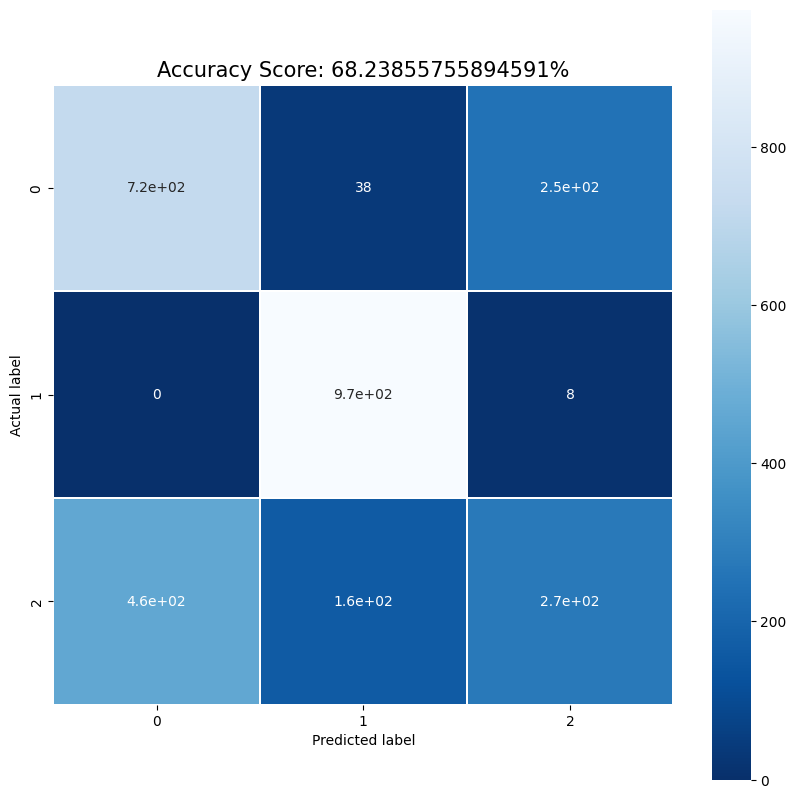

In [23]:
cm = metrics.confusion_matrix(test_y, predicion_mlp)
plt.figure(figsize=(10,10))
seaborn.heatmap(cm, annot=True, linewidths=.25, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}%'.format(resultados_mlp[0])
plt.title(all_sample_title, size = 15);

# Keras CNN<a class="anchor" id="Keras"></a>

In [44]:
from tensorflow.keras.datasets import mnist
import torch.nn.functional as F
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import datasets, layers, models
from keras.layers import Dense, Conv2D, Flatten,MaxPooling2D,BatchNormalization,Dropout
import tensorflow as tf

## 1.  Inicialización de variables <a class="anchor" id="Inicialización2"></a>

In [45]:
cpu_percent_list_train_keras = []
memory_usage_list_train_keras = []
cpu_percent_list_test_keras = []
memory_usage_list_test_keras = []
cpu_percent_list_train_keras2 = []
memory_usage_list_train_keras2 = []
cpu_percent_list_test_keras2 = []
memory_usage_list_test_keras2 = []
tf.random.set_seed(random_seed)

In [46]:
(train_x, train_y), (test_x, test_y) = mnist.load_data()

In [47]:
def lists_cpu_and_ram_keras_train():
    global running
    running = True

    currentProcess = psutil.Process()
    while running:
        cpu_percent_list_train_keras.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_train_keras.append(currentProcess.memory_percent())
        
def start_keras_train():
    global t

    t = threading.Thread(target=lists_cpu_and_ram_keras_train)
    t.start()

def stop_keras_train():
    global running
    global t

    running = False

    t.join()
    
def lists_cpu_and_ram_keras_test():
    global running
    running = True
    currentProcess = psutil.Process()

    while running:
        cpu_percent_list_test_keras.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_test_keras.append(currentProcess.memory_percent())
        
def start_keras_test():
    global t

    t = threading.Thread(target=lists_cpu_and_ram_keras_test)
    t.start()

def stop_keras_test():
    global running
    global t

    running = False

    t.join()
    
def lists_cpu_and_ram_keras_train2():
    global running
    running = True

    currentProcess = psutil.Process()
    while running:
        cpu_percent_list_train_keras2.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_train_keras2.append(currentProcess.memory_percent())
        
def start_keras_train2():
    global t

    t = threading.Thread(target=lists_cpu_and_ram_keras_train2)
    t.start()

def stop_keras_train2():
    global running
    global t

    running = False

    t.join()
    
def lists_cpu_and_ram_keras_test2():
    global running
    running = True
    currentProcess = psutil.Process()

    while running:
        cpu_percent_list_test_keras2.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_test_keras2.append(currentProcess.memory_percent())
        
def start_keras_test2():
    global t

    # create thread and start it
    t = threading.Thread(target=lists_cpu_and_ram_keras_test2)
    t.start()

def stop_keras_test2():
    global running
    global t

    running = False

    t.join()

In [48]:
train_indices = np.where((train_y == 3) | (train_y == 4) | (train_y == 5))
x_train_filtered = train_x[train_indices]
y_train_filtered = train_y[train_indices]
test_indices = np.where((test_y == 3) | (test_y == 4) | (test_y == 5))
x_test_filtered = test_x[test_indices]
y_test_filtered = test_y[test_indices]

y_train_filtered[y_train_filtered == 3] = 0
y_train_filtered[y_train_filtered == 4] = 1
y_train_filtered[y_train_filtered == 5] = 2
y_test_filtered[y_test_filtered == 3] = 0
y_test_filtered[y_test_filtered == 4] = 1
y_test_filtered[y_test_filtered == 5] = 2

train_y = y_train_filtered
test_y = y_test_filtered

train_x = np.array([resize(image, (4, 4)) for image in x_train_filtered])
test_x = np.array([resize(image, (4, 4)) for image in x_test_filtered])

train_x = np.expand_dims(train_x, axis=3)
test_x = np.expand_dims(test_x, axis=3)

train_x = train_x.astype('float32')
test_x = test_x.astype('float32')
train_x /= 255
test_x /= 255

In [49]:
train_y = to_categorical(train_y, num_classes)
test_y = to_categorical(test_y, num_classes)

## 2. Creacion de modelos <a class="anchor" id="Modelo2"></a>

In [50]:
model_keras = Sequential()
model_keras.add(Conv2D(input_shape=(4, 4, 1), filters=32, strides=(2, 2), padding='same', activation='relu', kernel_size=(3, 3)))
model_keras.add(Conv2D(filters=64, strides=(2, 2), padding='same', activation='relu', kernel_size=(3, 3)))
model_keras.add(Conv2D(filters=128, strides=(2, 2), padding='same', activation='relu', kernel_size=(3, 3)))
model_keras.add(Flatten())
model_keras.add(Dense(128, activation='relu'))
model_keras.add(Dropout(0.5))
model_keras.add(BatchNormalization())
model_keras.add(Dense(32, activation='relu'))
model_keras.add(Dense(3, activation='softmax'))

In [51]:
model_keras2 = Sequential()
model_keras2.add(Conv2D(input_shape=(4, 4, 1), filters=32, strides=(2, 2), padding='same', activation='relu', kernel_size=(3, 3)))
model_keras2.add(Conv2D(filters=64, strides=(2, 2), padding='same', activation='relu', kernel_size=(3, 3)))
model_keras2.add(Conv2D(filters=128, strides=(2, 2), padding='same', activation='relu', kernel_size=(3, 3)))
model_keras2.add(Flatten())
model_keras2.add(Dense(128, activation='relu'))
model_keras2.add(Dropout(0.5))
model_keras2.add(BatchNormalization())
model_keras2.add(Dense(32, activation='relu'))
model_keras2.add(Dense(3, activation='softmax'))

## 3. Entrenamiento <a class="anchor" id="Entrenamiento2"></a>

In [52]:
adam = Adam(learning_rate=0.0001) # ajustar la tasa de aprendizaje
batch_size2 = 32
model_keras.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
start_keras_train()
startTrainingTime_keras = time.time()
history_keras = model_keras.fit(train_x, train_y, batch_size=batch_size2, epochs=num_epochs, validation_split=0.1)
stop_keras_train()
stopTrainingTime_keras = time.time()
endTrainingTime_keras = stopTrainingTime_keras - startTrainingTime_keras 

Epoch 1/20
490/490 [==============================] - 1s 2ms/step - loss: 1.0982 - accuracy: 0.3470 - val_loss: 1.0976 - val_accuracy: 0.3517
Epoch 2/20
490/490 [==============================] - 1s 2ms/step - loss: 1.0976 - accuracy: 0.3489 - val_loss: 1.0975 - val_accuracy: 0.3517
Epoch 3/20
490/490 [==============================] - 1s 2ms/step - loss: 1.0978 - accuracy: 0.3524 - val_loss: 1.0973 - val_accuracy: 0.3517
Epoch 4/20
490/490 [==============================] - 1s 2ms/step - loss: 1.0975 - accuracy: 0.3542 - val_loss: 1.0973 - val_accuracy: 0.3517
Epoch 5/20
490/490 [==============================] - 1s 2ms/step - loss: 1.0975 - accuracy: 0.3508 - val_loss: 1.0973 - val_accuracy: 0.4931
Epoch 6/20
490/490 [==============================] - 1s 2ms/step - loss: 1.0974 - accuracy: 0.3535 - val_loss: 1.0967 - val_accuracy: 0.3517
Epoch 7/20
490/490 [==============================] - 1s 2ms/step - loss: 1.0810 - accuracy: 0.4310 - val_loss: 0.9872 - val_accuracy: 0.5902
Epoch 

In [53]:
adam = Adam(learning_rate=0.0001) # ajustar la tasa de aprendizaje
model_keras2.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
start_keras_train2()
startTrainingTime_keras2 = time.time()
history_keras2 = model_keras2.fit(train_x, train_y, batch_size=batch_size, epochs=num_epochs, validation_split=0.1)
stop_keras_train2()
stopTrainingTime_keras2 = time.time()
endTrainingTime_keras2 = stopTrainingTime_keras2 - startTrainingTime_keras2 

Epoch 1/20
979/979 [==============================] - 2s 2ms/step - loss: 1.0979 - accuracy: 0.3462 - val_loss: 1.0974 - val_accuracy: 0.3517
Epoch 2/20
979/979 [==============================] - 2s 2ms/step - loss: 1.0979 - accuracy: 0.3515 - val_loss: 1.0975 - val_accuracy: 0.3517
Epoch 3/20
979/979 [==============================] - 2s 2ms/step - loss: 1.0976 - accuracy: 0.3486 - val_loss: 1.0974 - val_accuracy: 0.3517
Epoch 4/20
979/979 [==============================] - 2s 2ms/step - loss: 1.0976 - accuracy: 0.3525 - val_loss: 1.0973 - val_accuracy: 0.3517
Epoch 5/20
979/979 [==============================] - 2s 2ms/step - loss: 1.0976 - accuracy: 0.3526 - val_loss: 1.0974 - val_accuracy: 0.3517
Epoch 6/20
979/979 [==============================] - 2s 2ms/step - loss: 1.0976 - accuracy: 0.3512 - val_loss: 1.0972 - val_accuracy: 0.3517
Epoch 7/20
979/979 [==============================] - 2s 2ms/step - loss: 1.0977 - accuracy: 0.3510 - val_loss: 1.0974 - val_accuracy: 0.3517
Epoch 

## 4. Resultados <a class="anchor" id="Resultados"></a>

In [60]:
start_keras_test()
starTestingTime_keras = time.time()

y_pred_prob_keras = model_keras.predict(test_x)
y_pred_keras = np.argmax(y_pred_prob_keras, axis=1)
y_true_keras = np.argmax(test_y, axis=1)

score = model_keras.evaluate(test_x, test_y, verbose=0)

sensitivity_keras = metrics.recall_score(y_true_keras, y_pred_keras, average='macro')
f_score_keras = metrics.f1_score(y_true_keras, y_pred_keras, average='macro')
kappa_keras = metrics.cohen_kappa_score(y_true_keras, y_pred_keras)

conf_matrix_keras = metrics.confusion_matrix(y_true_keras, y_pred_keras)

specificity_per_class_keras = []
for i in range(conf_matrix_keras.shape[0]):
    tn_keras = conf_matrix_keras[i, i]
    fp_keras = conf_matrix_keras[i, :].sum() - tn_keras
    specificity_keras = tn_keras / (tn_keras + fp_keras)
    specificity_per_class_keras.append(specificity_keras)

avg_specificity_keras = np.mean(specificity_per_class_keras)

stop_keras_test()
stopTestingTime_keras = time.time()
endTestingTime_keras = stopTestingTime_keras - starTestingTime_keras

print("Test loss:", score[0])
print("Test accuracy:", score[1])
print("Test sensitivity:", sensitivity_keras)
print("Test F1-score:", f_score_keras)
print(f"Cohen's Kappa: {kappa_keras}")
print(f"Especificidad media: {avg_specificity_keras}")

Test loss: 0.5136867761611938
Test accuracy: 0.7732316255569458
Test sensitivity: 0.7664816223615
Test F1-score: 0.7643922610968695
Cohen's Kappa: 0.6585800997323142
Promedio de Especificidad: 0.7664816223615


In [59]:
start_keras_test2()
starTestingTime_keras2 = time.time()

y_pred_prob_keras2 = model_keras2.predict(test_x)
y_pred_keras2 = np.argmax(y_pred_prob_keras2, axis=1)
y_true_keras2 = np.argmax(test_y, axis=1)

score2 = model_keras2.evaluate(test_x, test_y, verbose=0)

sensitivity_keras2 = metrics.recall_score(y_true_keras2, y_pred_keras2, average='macro')
f_score_keras2 = metrics.f1_score(y_true_keras2, y_pred_keras2, average='macro')
kappa_keras2 = metrics.cohen_kappa_score(y_true_keras2, y_pred_keras2)

conf_matrix_keras2 = metrics.confusion_matrix(y_true_keras2, y_pred_keras2)

specificity_per_class_keras2 = []
for i in range(conf_matrix_keras2.shape[0]):
    tn_keras2 = conf_matrix_keras2[i, i]
    fp_keras2 = conf_matrix_keras2[i, :].sum() - tn_keras2
    specificity_keras2 = tn_keras2 / (tn_keras2 + fp_keras2)
    specificity_per_class_keras2.append(specificity_keras2)

avg_specificity_keras2 = np.mean(specificity_per_class_keras2)

stop_keras_test2()
stopTestingTime_keras2 = time.time()
endTestingTime_keras2 = stopTestingTime_keras2 - starTestingTime_keras2

print("Test loss:", score2[0])
print("Test accuracy:", score2[1])
print("Test sensitivity:", sensitivity_keras2)
print("Test F1-score:", f_score_keras2)
print(f"Cohen's Kappa: {kappa_keras2}")
print(f"Especificidad media: {avg_specificity_keras2}")

Test loss: 0.5980391502380371
Test accuracy: 0.6903606057167053
Test sensitivity: 0.6718413935408684
Test F1-score: 0.6221337437574931
Cohen's Kappa: 0.5286381120135408
Promedio de Especificidad: 0.6718413935408684


# TensorFlow Quantum <a class="anchor" id="TensorFlow"></a>

In [35]:
import tensorflow as tf
from keras.layers import Dense, Conv2D, Flatten,MaxPooling2D,BatchNormalization,Dropout
import tensorflow_quantum as tfq
import cirq
import sympy
from cirq.contrib.svg import SVGCircuit
tf.random.set_seed(random_seed)

## Modelo V1 Simplificado Variables, carga y entrenamiento<a class="anchor" id="v1inicio"></a>

In [36]:
cpu_percent_list_train_tfq_v1 = []
memory_usage_list_train_tfq_v1= []
cpu_percent_list_test_tfq_v1= []
memory_usage_list_test_tfq_v1= []
learning_rate = 0.0001  

def lists_cpu_and_ram_tfq_train_v1():
    global running
    running = True

    currentProcess = psutil.Process()
    while running:
        cpu_percent_list_train_tfq_v1.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_train_tfq_v1.append(currentProcess.memory_percent())
        
def start_tfq_train_v1():
    global t

    t = threading.Thread(target=lists_cpu_and_ram_tfq_train_v1)
    t.start()

def stop_tfq_train_v1():
    global running
    global t

    running = False

    t.join()
    
def lists_cpu_and_ram_tfq_test_v1():
    global running
    running = True
    currentProcess = psutil.Process()

    while running:
        cpu_percent_list_test_tfq_v1.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_test_tfq_v1.append(currentProcess.memory_percent())
        
def start_tfq_test_v1():
    global t

    t = threading.Thread(target=lists_cpu_and_ram_tfq_test_v1)
    t.start()

def stop_tfq_test_v1():
    global running
    global t

    running = False

    t.join()

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

def filter_345(x, y):
    keep = (y == 3) | (y == 4) | (y == 5)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

x_train, y_train = filter_345(x_train, y_train)
x_test, y_test = filter_345(x_test, y_test)

x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)
    
    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          pass

    return np.array(new_x), np.array(new_y)

x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_nocon]
x_test_circ = [convert_to_circuit(x) for x in x_test_small]

x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)
            
def create_quantum_model():
    
    data_qubits = cirq.GridQubit.rect(4, 4)  
    readouts = [cirq.GridQubit(-1, -1), cirq.GridQubit(-2,-2), cirq.GridQubit(-3,-3), cirq.GridQubit(-4,-4)]         
    circuit = cirq.Circuit()
    
    for readout in readouts:
        circuit.append(cirq.X(readout))
        circuit.append(cirq.H(readout))
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

model_circuit, model_readout = create_quantum_model()
SVGCircuit(model_circuit)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    tfq.layers.PQC(model_circuit, model_readout),
])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

EPOCHS = 1
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

x_train_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_sub = y_train[:NUM_EXAMPLES]


start_tfq_train_v1()
startTrainingTime_tfq_v1 = time.time()

history_tfq_v1 = model.fit(
      x_train_tfcirc_sub, y_train_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

stop_tfq_train_v1()
stopTrainingTime_tfq_v1 = time.time()
endTrainingTime_tfq_v1 = stopTrainingTime_tfq_v1 - startTrainingTime_tfq_v1

445/445 [==============================] - 4879s 11s/step - loss: 4.1993e-08 - accuracy: 0.6477 - val_loss: -3.5713e-08 - val_accuracy: 0.0000e+00


## Modelo V1 Simplificado Resultados<a class="anchor" id="v1resultados"></a>

In [40]:
start_tfq_test_v1()
startTestingTime_tfq_v1 = time.time()

predictions_tfq_v1 = model.predict(x_test_tfcirc, batch_size=batch_size, verbose=1)
predicted_tfq_v1 = np.argmax(predictions_tfq_v1, axis=1)
y_true_tfq_v1 = y_test
y_pred_tfq_v1 = predicted_tfq_v1
test_loss_v1, test_acc_v1 = model.evaluate(x_test_tfcirc, y_test, batch_size=batch_size, verbose=1)
sensitivity_tfq_v1 = metrics.recall_score(y_test, predicted_tfq_v1, average='macro')
f_score_tfq_v1 = metrics.f1_score(y_test, predicted_tfq_v1, average='macro')
kappa_tfq_v1 = metrics.cohen_kappa_score(y_true_tfq_v1, y_pred_tfq_v1)
conf_matrix_tfq_v1 = metrics.confusion_matrix(y_true_tfq_v1, y_pred_tfq_v1)

specificity_per_class_tfq_v1 = []
for i in range(conf_matrix_tfq_v1.shape[0]):
    tn_tfq_v1 = conf_matrix_tfq_v1[i, i]
    fp_tfq_v1 = conf_matrix_tfq_v1[i, :].sum() - tn_tfq_v1
    specificity_tfq_v1 = tn_tfq_v1 / (tn_tfq_v1 + fp_tfq_v1)
    specificity_per_class_tfq_v1.append(specificity_tfq_v1)
avg_specificity_tfq_v1 = np.mean(specificity_per_class_tfq_v1)

stop_tfq_test_v1()
stopTestingTime_tfq_v1 = time.time()
endTestingTime_tfq_v1 = stopTestingTime_tfq_v1 - startTestingTime_tfq_v1
print("Test accuracy:", test_acc_v1)
print("Test sensitivity:", sensitivity_tfq_v1)
print("Test F1-score:", f_score_tfq_v1)
print(f"Cohen's Kappa: {kappa_tfq_v1}")
print(f"Especificidad media: {avg_specificity_tfq_v1}")

181/181 [==============================] - 124s 684ms/step - loss: 4.1748e-08 - accuracy: 0.6498
Test accuracy: 0.649791955947876
Test sensitivity: 0.5
Test F1-score: 0.39386296763345946
Cohen's Kappa: 0.0
Especificidad media: 0.5


## Carga de datos común modelos siguientes<a class="anchor" id="cargadatostfq"></a>

In [41]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train[..., np.newaxis], x_test[..., np.newaxis]

train_filter = np.where((y_train == 3) | (y_train == 4) | (y_train == 5))
test_filter = np.where((y_test == 3) | (y_test == 4) | (y_test == 5))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

In [42]:
def map_labels(y):
    label_mapping = {3: 0, 4: 1, 5: 2}
    return np.array([label_mapping[label] for label in y])

In [43]:
y_train_mapped = map_labels(y_train)
y_test_mapped = map_labels(y_test)

y_train = to_categorical(y_train_mapped, num_classes)
y_test = to_categorical(y_test_mapped, num_classes)

# Asegurar que el tamaño del conjunto de entrenamiento sea divisible por batch_size
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
num_train_batches = len(x_train) // batch_size
num_val_batches = len(x_val) // batch_size

x_train = x_train[:num_train_batches * batch_size]
y_train = y_train[:num_train_batches * batch_size]

x_val = x_val[:num_val_batches * batch_size]
y_val = y_val[:num_val_batches * batch_size]

In [44]:
def downsample(image, size=(4, 4)):
    return tf.image.resize(image, size)

In [45]:
qubits = cirq.GridQubit.rect(4, 4)
readout_operators = [cirq.Z(qubits[-1])]

In [46]:
def generate_data_circuit(x):
    circuit = cirq.Circuit()
    qubits = cirq.GridQubit.rect(4, 4)
    
    for i, pixel in enumerate(x.flatten()):
        if pixel:
            circuit.append(cirq.ry(np.pi * pixel).on(qubits[i]))
            circuit.append(cirq.rz(np.pi * pixel).on(qubits[i]))
    
    return circuit

In [47]:
x_train_downsampled = np.array([downsample(x) for x in x_train])
x_val_downsampled = np.array([downsample(x) for x in x_val])
x_test_downsampled = np.array([downsample(x) for x in x_test])

x_train_circuits = [generate_data_circuit(x) for x in x_train_downsampled]
x_val_circuits = [generate_data_circuit(x) for x in x_val_downsampled]
x_test_circuits = [generate_data_circuit(x) for x in x_test_downsampled]

x_train_tfcirc = tfq.convert_to_tensor(x_train_circuits)
x_val_tfcirc = tfq.convert_to_tensor(x_val_circuits)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circuits)

# Asegurar que el tamaño del conjunto de prueba sea divisible por batch_size
num_test_batches = len(x_test) // batch_size
x_test_downsampled = x_test_downsampled[:num_test_batches * batch_size]
x_test = x_test[:num_test_batches * batch_size]
y_test = y_test[:num_test_batches * batch_size]

x_test_tfcirc = tfq.convert_to_tensor(x_test_circuits[:num_test_batches * batch_size])

## Modelo V2 Simplificado variables y entrenamiento<a class="anchor" id="v2inicio"></a>

In [48]:
cpu_percent_list_train_tfq_v2 = []
memory_usage_list_train_tfq_v2= []
cpu_percent_list_test_tfq_v2= []
memory_usage_list_test_tfq_v2= []
num_quantum_layers = 2  
learning_rate = 0.1  
dropout_rate = 0.1  
l1_reg = 0 
l2_reg = 0 

def lists_cpu_and_ram_tfq_train_v2():
    global running
    running = True

    currentProcess = psutil.Process()
    while running:
        cpu_percent_list_train_tfq_v2.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_train_tfq_v2.append(currentProcess.memory_percent())
        
def start_tfq_train_v2():
    global t

    t = threading.Thread(target=lists_cpu_and_ram_tfq_train_v2)
    t.start()

def stop_tfq_train_v2():
    global running
    global t

    running = False

    t.join()
    
def lists_cpu_and_ram_tfq_test_v2():
    global running
    running = True
    currentProcess = psutil.Process()

    while running:
        cpu_percent_list_test_tfq_v2.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_test_tfq_v2.append(currentProcess.memory_percent())
        
def start_tfq_test_v2():
    global t

    t = threading.Thread(target=lists_cpu_and_ram_tfq_test_v2)
    t.start()

def stop_tfq_test_v2():
    global running
    global t

    running = False

    t.join()
    
def generate_model_circuit(qubits, num_layers):
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols(f"theta(0:{16 * num_layers})")

    for layer in range(num_layers):
        for i in range(0, 16, 4):
            model_circuit += cirq.Circuit(
                cirq.rx(symbols[16 * layer + i]).on(qubits[i]),
                cirq.rz(symbols[16 * layer + i + 1]).on(qubits[i + 1]),
                cirq.rx(symbols[16 * layer + i + 2]).on(qubits[i + 2]),
                cirq.rz(symbols[16 * layer + i + 3]).on(qubits[i + 3]),
            )

            model_circuit += cirq.Circuit(
                cirq.CZ(qubits[i], qubits[i + 1]),
                cirq.CZ(qubits[i + 1], qubits[i + 2]),
                cirq.CZ(qubits[i + 2], qubits[i + 3]),
            )

        model_circuit += cirq.Circuit(
            cirq.CZ(qubits[0], qubits[3]),
            cirq.CZ(qubits[12], qubits[15]),
        )

    return model_circuit

model_circuit = generate_model_circuit(qubits, num_quantum_layers)
quantum_model = tfq.layers.PQC(model_circuit, readout_operators)

inputs = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
quantum = quantum_model(inputs)

dense_input = tf.keras.Input(shape=(4, 4, 1), name='dense_input')
quantum_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string, name='quantum_input', batch_size=batch_size)

flatten = Flatten()(dense_input)
dense_classic_1 = tf.keras.layers.Dense(32, activation=tf.keras.activations.relu)(flatten)
dense_classic_2 = tf.keras.layers.Dense(16, activation=tf.keras.activations.relu)(dense_classic_1)
reshaped = tf.keras.layers.Reshape((4, 4, 1))(dense_classic_2)
downsampled = downsample(reshaped)

flat_downsampled = Flatten()(downsampled)

quantum = quantum_model(quantum_input)

concat = tf.keras.layers.Concatenate()([flat_downsampled, quantum])
dense_1 = tf.keras.layers.Dense(64, activation=tf.keras.activations.relu)(concat)
dense_2 = tf.keras.layers.Dense(32, activation=tf.keras.activations.relu)(dense_1)
dropout = tf.keras.layers.Dropout(dropout_rate)(dense_2)
outputs = tf.keras.layers.Dense(num_classes, activation=tf.keras.activations.softmax)(dropout)

model_tfq_v2 = tf.keras.Model(inputs=[dense_input, quantum_input], outputs=outputs)
model_tfq_v2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

start_tfq_train_v2()
startTrainingTime_tfq_v2 = time.time()
history_tfq_v2 = model_tfq_v2.fit(
    [x_train_downsampled, x_train_tfcirc], y_train, 
    batch_size=batch_size, epochs=5, verbose=1, 
    validation_data=([x_val_downsampled, x_val_tfcirc], y_val)
)
stop_tfq_train_v2()
stopTrainingTime_tfq_v2 = time.time()
endTrainingTime_tfq_v2 = stopTrainingTime_tfq_v2 - startTrainingTime_tfq_v2

Epoch 1/5
869/869 [==============================] - 83s 96ms/step - loss: 1.1111 - accuracy: 0.3347 - val_loss: 1.1010 - val_accuracy: 0.3528
Epoch 2/5
869/869 [==============================] - 81s 94ms/step - loss: 1.1061 - accuracy: 0.3372 - val_loss: 1.1072 - val_accuracy: 0.3119
Epoch 3/5
869/869 [==============================] - 82s 94ms/step - loss: 1.1069 - accuracy: 0.3379 - val_loss: 1.1003 - val_accuracy: 0.3528
Epoch 4/5
869/869 [==============================] - 81s 94ms/step - loss: 1.1042 - accuracy: 0.3380 - val_loss: 1.0992 - val_accuracy: 0.3528
Epoch 5/5
869/869 [==============================] - 83s 96ms/step - loss: 1.1056 - accuracy: 0.3373 - val_loss: 1.1001 - val_accuracy: 0.3119


## Modelo V2 Resultados<a class="anchor" id="v2resultados"></a>

In [49]:
start_tfq_test_v2()
startTestingTime_tfq_v2 = time.time()

predictions_tfq_v2 = model_tfq_v2.predict([x_test_downsampled, x_test_tfcirc], batch_size=batch_size, verbose=1)
predicted_tfq_v2 = np.argmax(predictions_tfq_v2, axis=1)
y_true_tfq_v2 = np.argmax(y_test, axis=1)
y_pred_tfq_v2 = predicted_tfq_v2
test_loss_v2, test_acc_v2 = model_tfq_v2.evaluate([x_test_downsampled, x_test_tfcirc], y_test, batch_size=batch_size, verbose=1)
sensitivity_tfq_v2 = metrics.recall_score(np.argmax(y_test, axis=1), predicted_tfq_v2, average='macro')
f_score_tfq_v2 = metrics.f1_score(np.argmax(y_test, axis=1), predicted_tfq_v2, average='macro')
kappa_tfq_v2 = metrics.cohen_kappa_score(y_true_tfq_v2, y_pred_tfq_v2)
conf_matrix_tfq_v2 = metrics.confusion_matrix(y_true_tfq_v2, y_pred_tfq_v2)

specificity_per_class_tfq_v2 = []
for i in range(conf_matrix_tfq_v2.shape[0]):
    tn_tfq_v2 = conf_matrix_tfq_v2[i, i]
    fp_tfq_v2 = conf_matrix_tfq_v2[i, :].sum() - tn_tfq_v2
    specificity_tfq_v2 = tn_tfq_v2 / (tn_tfq_v2 + fp_tfq_v2)
    specificity_per_class_tfq_v2.append(specificity_tfq_v2)
avg_specificity_tfq_v2 = np.mean(specificity_per_class_tfq_v2)

stop_tfq_test_v2()
stopTestingTime_tfq_v2 = time.time()
endTestingTime_tfq_v2 = stopTestingTime_tfq_v2 - startTestingTime_tfq_v2
print("Test accuracy:", test_acc_v2)
print("Test sensitivity:", sensitivity_tfq_v2)
print("Test F1-score:", f_score_tfq_v2)
print(f"Cohen's Kappa: {kappa_tfq_v2}")
print(f"Especificidad media: {avg_specificity_tfq_v2}")

180/180 [==============================] - 3s 19ms/step - loss: 1.1000 - accuracy: 0.3090
Test accuracy: 0.3090277910232544
Test sensitivity: 0.3333333333333333
Test F1-score: 0.15738284703801947
Cohen's Kappa: 0.0
Especificidad media: 0.3333333333333333


## Modelo V3 Simplificado variables y entrenamiento<a class="anchor" id="v3inicio"></a>

In [50]:
cpu_percent_list_train_tfq_v3 = []
memory_usage_list_train_tfq_v3= []
cpu_percent_list_test_tfq_v3= []
memory_usage_list_test_tfq_v3= []
num_quantum_layers = 3  
dense_layer_sizes = [64, 32] 
learning_rate = 0.01  
dropout_rate = 0.2  
l1_reg = 0 
l2_reg = 0 

def lists_cpu_and_ram_tfq_train_v3():
    global running
    running = True

    currentProcess = psutil.Process()
    while running:
        cpu_percent_list_train_tfq_v3.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_train_tfq_v3.append(currentProcess.memory_percent())
        
def start_tfq_train_v3():
    global t

    t = threading.Thread(target=lists_cpu_and_ram_tfq_train_v3)
    t.start()

def stop_tfq_train_v3():
    global running
    global t

    running = False

    t.join()
    
def lists_cpu_and_ram_tfq_test_v3():
    global running
    running = True
    currentProcess = psutil.Process()

    while running:
        cpu_percent_list_test_tfq_v3.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_test_tfq_v3.append(currentProcess.memory_percent())
        
def start_tfq_test_v3():
    global t

    t = threading.Thread(target=lists_cpu_and_ram_tfq_test_v3)
    t.start()

def stop_tfq_test_v3():
    global running
    global t

    running = False

    t.join()
    
def generate_model_circuit(qubits, num_layers):
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols(f"theta(0:{16 * num_layers})")

    for layer in range(num_layers):
        for i in range(0, 16, 4):
            model_circuit += cirq.Circuit(
                cirq.rx(symbols[16 * layer + i]).on(qubits[i]),
                cirq.rz(symbols[16 * layer + i + 1]).on(qubits[i + 1]),
                cirq.rx(symbols[16 * layer + i + 2]).on(qubits[i + 2]),
                cirq.rz(symbols[16 * layer + i + 3]).on(qubits[i + 3]),
            )

            model_circuit += cirq.Circuit(
                cirq.CZ(qubits[i], qubits[i + 1]),
                cirq.CZ(qubits[i + 1], qubits[i + 2]),
                cirq.CZ(qubits[i + 2], qubits[i + 3]),
            )

        model_circuit += cirq.Circuit(
            cirq.CZ(qubits[0], qubits[3]),
            cirq.CZ(qubits[12], qubits[15]),
        )

    return model_circuit

odel_circuit = generate_model_circuit(qubits, num_quantum_layers)
quantum_model = tfq.layers.PQC(model_circuit, readout_operators)

inputs = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
quantum = quantum_model(inputs)

dense_input = tf.keras.Input(shape=(4, 4, 1), name='dense_input')
quantum_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string, name='quantum_input', batch_size=batch_size)

flatten = Flatten()(dense_input)
dense_classic_1 = tf.keras.layers.Dense(32, activation=tf.keras.activations.relu)(flatten)
dense_classic_2 = tf.keras.layers.Dense(16, activation=tf.keras.activations.relu)(dense_classic_1)
reshaped = tf.keras.layers.Reshape((4, 4, 1))(dense_classic_2)
downsampled = downsample(reshaped)

flat_downsampled = Flatten()(downsampled)

quantum = quantum_model(quantum_input)

concat = tf.keras.layers.Concatenate()([flat_downsampled, quantum])
dense_1 = tf.keras.layers.Dense(64, activation=tf.keras.activations.relu)(concat)
dense_2 = tf.keras.layers.Dense(32, activation=tf.keras.activations.relu)(dense_1)
dropout = tf.keras.layers.Dropout(dropout_rate)(dense_2)
outputs = tf.keras.layers.Dense(num_classes, activation=tf.keras.activations.softmax)(dropout)

model_tfq_v3 = tf.keras.Model(inputs=[dense_input, quantum_input], outputs=outputs)
model_tfq_v3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

start_tfq_train_v3()
startTrainingTime_tfq_v3 = time.time()
history_tfq_v3 = model_tfq_v3.fit(
    [x_train_downsampled, x_train_tfcirc], y_train, 
    batch_size=batch_size, epochs=10, verbose=1, 
    validation_data=([x_val_downsampled, x_val_tfcirc], y_val)
)
stop_tfq_train_v3()
stopTrainingTime_tfq_v3 = time.time()
endTrainingTime_tfq_v3 = stopTrainingTime_tfq_v3 - startTrainingTime_tfq_v3

Epoch 1/10
869/869 [==============================] - 83s 95ms/step - loss: 0.7851 - accuracy: 0.6684 - val_loss: 0.7318 - val_accuracy: 0.7042
Epoch 2/10
869/869 [==============================] - 82s 95ms/step - loss: 0.7517 - accuracy: 0.6867 - val_loss: 0.7042 - val_accuracy: 0.6979
Epoch 3/10
869/869 [==============================] - 83s 96ms/step - loss: 0.7382 - accuracy: 0.6910 - val_loss: 0.6944 - val_accuracy: 0.7071
Epoch 4/10
869/869 [==============================] - 83s 96ms/step - loss: 0.7253 - accuracy: 0.7000 - val_loss: 0.6919 - val_accuracy: 0.7163
Epoch 5/10
869/869 [==============================] - 83s 95ms/step - loss: 0.7230 - accuracy: 0.7013 - val_loss: 0.6868 - val_accuracy: 0.7105
Epoch 6/10
869/869 [==============================] - 83s 96ms/step - loss: 0.7146 - accuracy: 0.7050 - val_loss: 0.6826 - val_accuracy: 0.7154
Epoch 7/10
869/869 [==============================] - 84s 96ms/step - loss: 0.7145 - accuracy: 0.7094 - val_loss: 0.6771 - val_accuracy:

## Modelo V3 Resultados<a class="anchor" id="v3resultados"></a>

In [51]:
start_tfq_test_v3()
startTestingTime_tfq_v3 = time.time()

predictions_tfq_v3 = model_tfq_v3.predict([x_test_downsampled, x_test_tfcirc], batch_size=batch_size, verbose=1)
predicted_tfq_v3 = np.argmax(predictions_tfq_v3, axis=1)
y_true_tfq_v3 = np.argmax(y_test, axis=1)
y_pred_tfq_v3 = predicted_tfq_v3
test_loss_v3, test_acc_v3 = model_tfq_v3.evaluate([x_test_downsampled, x_test_tfcirc], y_test, batch_size=batch_size, verbose=1)
sensitivity_tfq_v3 = metrics.recall_score(np.argmax(y_test, axis=1), predicted_tfq_v3, average='macro')
f_score_tfq_v3 = metrics.f1_score(np.argmax(y_test, axis=1), predicted_tfq_v3, average='macro')
kappa_tfq_v3 = metrics.cohen_kappa_score(y_true_tfq_v3, y_pred_tfq_v3)
conf_matrix_tfq_v3 = metrics.confusion_matrix(y_true_tfq_v3, y_pred_tfq_v3)

specificity_per_class_tfq_v3 = []
for i in range(conf_matrix_tfq_v3.shape[0]):
    tn_tfq_v3 = conf_matrix_tfq_v3[i, i]
    fp_tfq_v3 = conf_matrix_tfq_v3[i, :].sum() - tn_tfq_v3
    specificity_tfq_v3 = tn_tfq_v3 / (tn_tfq_v3 + fp_tfq_v3)
    specificity_per_class_tfq_v3.append(specificity_tfq_v3)
avg_specificity_tfq_v3 = np.mean(specificity_per_class_tfq_v3)

stop_tfq_test_v3()
stopTestingTime_tfq_v3 = time.time()
endTestingTime_tfq_v3 = stopTestingTime_tfq_v3 - startTestingTime_tfq_v3
print("Test accuracy:", test_acc_v3)
print("Test sensitivity:", sensitivity_tfq_v3)
print("Test F1-score:", f_score_tfq_v3)
print(f"Cohen's Kappa: {kappa_tfq_v3}")
print(f"Especificidad media: {avg_specificity_tfq_v3}")

180/180 [==============================] - 3s 17ms/step - loss: 0.6594 - accuracy: 0.7281
Test accuracy: 0.7281249761581421
Test sensitivity: 0.7245012649122389
Test F1-score: 0.7252830820407342
Cohen's Kappa: 0.590353290857992
Especificidad media: 0.7245012649122389


## Modelo V4 Simplificado variables y entrenamiento<a class="anchor" id="v4inicio"></a>

In [52]:
cpu_percent_list_train_tfq_v4 = []
memory_usage_list_train_tfq_v4= []
cpu_percent_list_test_tfq_v4= []
memory_usage_list_test_tfq_v4= []
num_quantum_layers = 4  
dense_layer_sizes = [64, 32] 
learning_rate = 0.001  
dropout_rate = 0.3  
l1_reg = 0 
l2_reg = 0 

def lists_cpu_and_ram_tfq_train_v4():
    global running
    running = True

    currentProcess = psutil.Process()
    while running:
        cpu_percent_list_train_tfq_v4.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_train_tfq_v4.append(currentProcess.memory_percent())
        
def start_tfq_train_v4():
    global t

    t = threading.Thread(target=lists_cpu_and_ram_tfq_train_v4)
    t.start()

def stop_tfq_train_v4():
    global running
    global t

    running = False

    t.join()
    
def lists_cpu_and_ram_tfq_test_v4():
    global running
    running = True
    currentProcess = psutil.Process()

    while running:
        cpu_percent_list_test_tfq_v4.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_test_tfq_v4.append(currentProcess.memory_percent())
        
def start_tfq_test_v4():
    global t

    t = threading.Thread(target=lists_cpu_and_ram_tfq_test_v4)
    t.start()

def stop_tfq_test_v4():
    global running
    global t

    running = False

    t.join()
    
def generate_model_circuit(qubits, num_layers):
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols(f"theta(0:{16 * num_layers})")

    for layer in range(num_layers):
        for i in range(0, 16, 4):
            model_circuit += cirq.Circuit(
                cirq.rx(symbols[16 * layer + i]).on(qubits[i]),
                cirq.rz(symbols[16 * layer + i + 1]).on(qubits[i + 1]),
                cirq.rx(symbols[16 * layer + i + 2]).on(qubits[i + 2]),
                cirq.rz(symbols[16 * layer + i + 3]).on(qubits[i + 3]),
            )

            model_circuit += cirq.Circuit(
                cirq.CZ(qubits[i], qubits[i + 1]),
                cirq.CZ(qubits[i + 1], qubits[i + 2]),
                cirq.CZ(qubits[i + 2], qubits[i + 3]),
            )

        model_circuit += cirq.Circuit(
            cirq.CZ(qubits[0], qubits[3]),
            cirq.CZ(qubits[12], qubits[15]),
        )

    return model_circuit

model_circuit = generate_model_circuit(qubits, num_quantum_layers)
quantum_model = tfq.layers.PQC(model_circuit, readout_operators)

inputs = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
quantum = quantum_model(inputs)

dense_input = tf.keras.Input(shape=(4, 4, 1), name='dense_input')
quantum_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string, name='quantum_input', batch_size=batch_size)

flatten = Flatten()(dense_input)
dense_classic_1 = tf.keras.layers.Dense(32, activation=tf.keras.activations.relu)(flatten)
dense_classic_2 = tf.keras.layers.Dense(16, activation=tf.keras.activations.relu)(dense_classic_1)
reshaped = tf.keras.layers.Reshape((4, 4, 1))(dense_classic_2)
downsampled = downsample(reshaped)

flat_downsampled = Flatten()(downsampled)

quantum = quantum_model(quantum_input)

concat = tf.keras.layers.Concatenate()([flat_downsampled, quantum])
dense_1 = tf.keras.layers.Dense(64, activation=tf.keras.activations.relu)(concat)
dense_2 = tf.keras.layers.Dense(32, activation=tf.keras.activations.relu)(dense_1)
dropout = tf.keras.layers.Dropout(dropout_rate)(dense_2)
outputs = tf.keras.layers.Dense(num_classes, activation=tf.keras.activations.softmax)(dropout)

model_tfq_v4 = tf.keras.Model(inputs=[dense_input, quantum_input], outputs=outputs)
model_tfq_v4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

start_tfq_train_v4()
startTrainingTime_tfq_v4 = time.time()
history_tfq_v4 = model_tfq_v4.fit(
    [x_train_downsampled, x_train_tfcirc], y_train, 
    batch_size=batch_size, epochs=15, verbose=1, 
    validation_data=([x_val_downsampled, x_val_tfcirc], y_val)
)
stop_tfq_train_v4()
stopTrainingTime_tfq_v4 = time.time()
endTrainingTime_tfq_v4 = stopTrainingTime_tfq_v4 - startTrainingTime_tfq_v4

Epoch 1/15
869/869 [==============================] - 149s 171ms/step - loss: 0.8104 - accuracy: 0.6522 - val_loss: 0.7196 - val_accuracy: 0.6961
Epoch 2/15
869/869 [==============================] - 151s 174ms/step - loss: 0.7405 - accuracy: 0.6912 - val_loss: 0.6907 - val_accuracy: 0.7048
Epoch 3/15
869/869 [==============================] - 150s 173ms/step - loss: 0.7251 - accuracy: 0.6977 - val_loss: 0.6930 - val_accuracy: 0.6961
Epoch 4/15
869/869 [==============================] - 151s 174ms/step - loss: 0.7157 - accuracy: 0.7043 - val_loss: 0.6803 - val_accuracy: 0.7166
Epoch 5/15
869/869 [==============================] - 150s 173ms/step - loss: 0.7108 - accuracy: 0.7031 - val_loss: 0.6789 - val_accuracy: 0.7108
Epoch 6/15
869/869 [==============================] - 150s 173ms/step - loss: 0.7054 - accuracy: 0.7061 - val_loss: 0.6821 - val_accuracy: 0.7108
Epoch 7/15
869/869 [==============================] - 150s 173ms/step - loss: 0.7045 - accuracy: 0.7057 - val_loss: 0.6688 -

## Modelo V4 Resultados<a class="anchor" id="v4resultados"></a>

In [54]:
start_tfq_test_v4()
startTestingTime_tfq_v4 = time.time()

predictions_tfq_v4 = model_tfq_v4.predict([x_test_downsampled, x_test_tfcirc], batch_size=batch_size, verbose=1)
predicted_tfq_v4 = np.argmax(predictions_tfq_v4, axis=1)
y_true_tfq_v4 = np.argmax(y_test, axis=1)
y_pred_tfq_v4 = predicted_tfq_v4
test_loss_v4, test_acc_v4 = model_tfq_v4.evaluate([x_test_downsampled, x_test_tfcirc], y_test, batch_size=batch_size, verbose=1)
sensitivity_tfq_v4 = metrics.recall_score(np.argmax(y_test, axis=1), predicted_tfq_v4, average='macro')
f_score_tfq_v4 = metrics.f1_score(np.argmax(y_test, axis=1), predicted_tfq_v4, average='macro')
kappa_tfq_v4 = metrics.cohen_kappa_score(y_true_tfq_v4, y_pred_tfq_v4)
conf_matrix_tfq_v4 = metrics.confusion_matrix(y_true_tfq_v4, y_pred_tfq_v4)

specificity_per_class_tfq_v4 = []
for i in range(conf_matrix_tfq_v4.shape[0]):
    tn_tfq_v4 = conf_matrix_tfq_v4[i, i]
    fp_tfq_v4 = conf_matrix_tfq_v4[i, :].sum() - tn_tfq_v4
    specificity_tfq_v4 = tn_tfq_v4 / (tn_tfq_v4 + fp_tfq_v4)
    specificity_per_class_tfq_v4.append(specificity_tfq_v4)
avg_specificity_tfq_v4 = np.mean(specificity_per_class_tfq_v4)

stop_tfq_test_v4()
stopTestingTime_tfq_v4 = time.time()
endTestingTime_tfq_v4 = stopTestingTime_tfq_v4 - startTestingTime_tfq_v4
print("Test accuracy:", test_acc_v4)
print("Test sensitivity:", sensitivity_tfq_v4)
print("Test F1-score:", f_score_tfq_v4)
print(f"Cohen's Kappa: {kappa_tfq_v4}")
print(f"Especificidad media: {avg_specificity_tfq_v4}")

180/180 [==============================] - 6s 31ms/step - loss: 0.6449 - accuracy: 0.7278
Test accuracy: 0.7277777791023254
Test sensitivity: 0.7237962038485194
Test F1-score: 0.7241517274155859
Cohen's Kappa: 0.5897685598603928
Especificidad media: 0.7237962038485194


## 1.  Inicialización de variables modelo v5<a class="anchor" id="Inicialización3"></a>

In [55]:
cpu_percent_list_train_tfq_v5 = []
memory_usage_list_train_tfq_v5= []
cpu_percent_list_test_tfq_v5= []
memory_usage_list_test_tfq_v5= []
num_quantum_layers = 5  
dense_layer_sizes = [64, 32] 
learning_rate = 0.0001  
dropout_rate = 0.4  
l1_reg = 0 
l2_reg = 0  

In [56]:
def lists_cpu_and_ram_tfq_train_v5():
    global running
    running = True

    currentProcess = psutil.Process()
    while running:
        cpu_percent_list_train_tfq_v5.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_train_tfq_v5.append(currentProcess.memory_percent())
        
def start_tfq_train_v5():
    global t

    t = threading.Thread(target=lists_cpu_and_ram_tfq_train_v5)
    t.start()

def stop_tfq_train_v5():
    global running
    global t

    running = False

    t.join()

In [57]:
def lists_cpu_and_ram_tfq_test_v5():
    global running
    running = True
    currentProcess = psutil.Process()

    while running:
        cpu_percent_list_test_tfq_v5.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_test_tfq_v5.append(currentProcess.memory_percent())
        
def start_tfq_test_v5():
    global t

    t = threading.Thread(target=lists_cpu_and_ram_tfq_test_v5)
    t.start()

def stop_tfq_test_v5():
    global running
    global t

    running = False

    t.join()

## 2. Arquitectura modelo V5<a class="anchor" id="Clases"></a>

In [58]:
def generate_model_circuit(qubits, num_layers):
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols(f"theta(0:{16 * num_layers})")

    for layer in range(num_layers):
        for i in range(0, 16, 4):
            model_circuit += cirq.Circuit(
                cirq.rx(symbols[16 * layer + i]).on(qubits[i]),
                cirq.rz(symbols[16 * layer + i + 1]).on(qubits[i + 1]),
                cirq.rx(symbols[16 * layer + i + 2]).on(qubits[i + 2]),
                cirq.rz(symbols[16 * layer + i + 3]).on(qubits[i + 3]),
            )

            model_circuit += cirq.Circuit(
                cirq.CZ(qubits[i], qubits[i + 1]),
                cirq.CZ(qubits[i + 1], qubits[i + 2]),
                cirq.CZ(qubits[i + 2], qubits[i + 3]),
            )

        model_circuit += cirq.Circuit(
            cirq.CZ(qubits[0], qubits[3]),
            cirq.CZ(qubits[12], qubits[15]),
        )

    return model_circuit

## 3. Modelo Híbrido V5 <a class="anchor" id="Modelo3"></a>

In [59]:
model_circuit = generate_model_circuit(qubits, num_quantum_layers)
quantum_model = tfq.layers.PQC(model_circuit, readout_operators)

In [60]:
# Entradas
dense_input = tf.keras.Input(shape=(4, 4, 1), name='dense_input')
quantum_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string, name='quantum_input', batch_size=batch_size)

# Circuito cuántico
flatten = Flatten()(dense_input)
dense_classic_1 = tf.keras.layers.Dense(32, activation=tf.keras.activations.relu)(flatten)
dense_classic_2 = tf.keras.layers.Dense(16, activation=tf.keras.activations.relu)(dense_classic_1)
reshaped = tf.keras.layers.Reshape((4, 4, 1))(dense_classic_2)
downsampled = downsample(reshaped)

# Aplanar la salida de downsampled
flat_downsampled = Flatten()(downsampled)

# Red cuántica
quantum = quantum_model(quantum_input)

# Modelo híbrido
concat = tf.keras.layers.Concatenate()([flat_downsampled, quantum])
dense_1 = tf.keras.layers.Dense(64, activation=tf.keras.activations.relu)(concat)
dense_2 = tf.keras.layers.Dense(32, activation=tf.keras.activations.relu)(dense_1)
dropout = tf.keras.layers.Dropout(dropout_rate)(dense_2)
outputs = tf.keras.layers.Dense(num_classes, activation=tf.keras.activations.softmax)(dropout)

# Crea el modelo
model_tfq_v5 = tf.keras.Model(inputs=[dense_input, quantum_input], outputs=outputs)

In [61]:
model_tfq_v5 = tf.keras.Model(inputs=[dense_input, quantum_input], outputs=outputs)
model_tfq_v5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

## 4. Entrenamiento V5 <a class="anchor" id="Entrenamiento3"></a>

In [62]:
start_tfq_train_v5()
startTrainingTime_tfq_v5 = time.time()
history_tfq_v5 = model_tfq_v5.fit(
    [x_train_downsampled, x_train_tfcirc], y_train, 
    batch_size=batch_size, epochs=20, verbose=1, 
    validation_data=([x_val_downsampled, x_val_tfcirc], y_val)
)
stop_tfq_train_v5()
stopTrainingTime_tfq_v5 = time.time()
endTrainingTime_tfq_v5 = stopTrainingTime_tfq_v5 - startTrainingTime_tfq_v5

Epoch 1/20
869/869 [==============================] - 186s 213ms/step - loss: 1.0416 - accuracy: 0.4730 - val_loss: 0.9092 - val_accuracy: 0.6544
Epoch 2/20
869/869 [==============================] - 182s 209ms/step - loss: 0.8569 - accuracy: 0.6361 - val_loss: 0.7712 - val_accuracy: 0.6789
Epoch 3/20
869/869 [==============================] - 183s 211ms/step - loss: 0.8082 - accuracy: 0.6543 - val_loss: 0.7501 - val_accuracy: 0.6832
Epoch 4/20
869/869 [==============================] - 182s 210ms/step - loss: 0.7881 - accuracy: 0.6714 - val_loss: 0.7346 - val_accuracy: 0.6838
Epoch 5/20
869/869 [==============================] - 182s 209ms/step - loss: 0.7792 - accuracy: 0.6735 - val_loss: 0.7262 - val_accuracy: 0.6941
Epoch 6/20
869/869 [==============================] - 182s 210ms/step - loss: 0.7688 - accuracy: 0.6794 - val_loss: 0.7203 - val_accuracy: 0.6901
Epoch 7/20
869/869 [==============================] - 182s 209ms/step - loss: 0.7630 - accuracy: 0.6837 - val_loss: 0.7141 -

## 5. Resultados V5<a class="anchor" id="Resultados3"></a>

In [63]:
start_tfq_test_v5()
startTestingTime_tfq_v5 = time.time()

predictions_tfq = model_tfq_v5.predict([x_test_downsampled, x_test_tfcirc], batch_size=batch_size, verbose=1)
predicted_tfq = np.argmax(predictions_tfq, axis=1)
y_true_tfq = np.argmax(y_test, axis=1)
y_pred_tfq = predicted_tfq
test_loss, test_acc = model_tfq_v5.evaluate([x_test_downsampled, x_test_tfcirc], y_test, batch_size=batch_size, verbose=1)
sensitivity_tfq = metrics.recall_score(np.argmax(y_test, axis=1), predicted_tfq, average='macro')
f_score_tfq = metrics.f1_score(np.argmax(y_test, axis=1), predicted_tfq, average='macro')
kappa_tfq = metrics.cohen_kappa_score(y_true_tfq, y_pred_tfq)
conf_matrix_tfq = metrics.confusion_matrix(y_true_tfq, y_pred_tfq)

specificity_per_class_tfq = []
for i in range(conf_matrix_tfq.shape[0]):
    tn_tfq = conf_matrix_tfq[i, i]
    fp_tfq = conf_matrix_tfq[i, :].sum() - tn_tfq
    specificity_tfq = tn_tfq / (tn_tfq + fp_tfq)
    specificity_per_class_tfq.append(specificity_tfq)
avg_specificity_tfq = np.mean(specificity_per_class_tfq)

stop_tfq_test_v5()
stopTestingTime_tfq_v5 = time.time()
endTestingTime_tfq_v5 = stopTestingTime_tfq_v5 - startTestingTime_tfq_v5
print("Test accuracy:", test_acc)
print("Test sensitivity:", sensitivity_tfq)
print("Test F1-score:", f_score_tfq)
print(f"Cohen's Kappa: {kappa_tfq}")
print(f"Especificidad media: {avg_specificity_tfq}")

180/180 [==============================] - 7s 38ms/step - loss: 0.6681 - accuracy: 0.7205
Test accuracy: 0.7204861044883728
Test sensitivity: 0.7192439160120809
Test F1-score: 0.7193568772912625
Cohen's Kappa: 0.5800550797322959
Especificidad media: 0.7192439160120809


# Qiskit <a class="anchor" id="qiskit"></a>

In [3]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from qiskit import QuantumCircuit
from qiskit.utils import algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
from qiskit import QuantumCircuit, transpile, Aer, execute
from qiskit.circuit import Parameter
from qiskit.circuit.library import ZFeatureMap
from qiskit.opflow import Z, StateFn
from qiskit.utils import QuantumInstance

## 1.  Inicialización de variables <a class="anchor" id="Inicialización4"></a>

In [4]:
cpu_percent_list_train_q= []
memory_usage_list_train_q= []
cpu_percent_list_test_q= []
memory_usage_list_test_q= []
n_samples = None

def lists_cpu_and_ram_q_train():
    global running
    running = True

    currentProcess = psutil.Process()
    while running:
        cpu_percent_list_train_q.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_train_q.append(currentProcess.memory_percent())
        
def start_q_train():
    global t

    # create thread and start it
    t = threading.Thread(target=lists_cpu_and_ram_q_train)
    t.start()

def stop_q_train():
    global running
    global t

    # use `running` to stop loop in thread so thread will end
    running = False

    # wait for thread's end
    t.join()
    
def lists_cpu_and_ram_q_test():
    global running
    running = True
    currentProcess = psutil.Process()

    while running:
        cpu_percent_list_test_q.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_test_q.append(currentProcess.memory_percent())
        
def start_q_test():
    global t

    # create thread and start it
    t = threading.Thread(target=lists_cpu_and_ram_q_test)
    t.start()

def stop_q_test():
    global running
    global t

    # use `running` to stop loop in thread so thread will end
    running = False

    # wait for thread's end
    t.join()

In [5]:
X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

idx_3 = np.where(X_train.targets == 3)[0][:n_samples]
idx_6 = np.where(X_train.targets == 4)[0][:n_samples]
idx_9 = np.where(X_train.targets == 5)[0][:n_samples]
idx = np.concatenate((idx_3, idx_6, idx_9), axis=0)

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]
X_train.targets[X_train.targets == 3] = 0
X_train.targets[X_train.targets == 4] = 1
X_train.targets[X_train.targets == 5] = 2

X_train.data = torch.nn.functional.interpolate(X_train.data.unsqueeze(1).float(), size=(4,4)).squeeze()

X_train.data = X_train.data/255.0

train_loader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True)

In [6]:
X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idy_3 = np.where(X_test.targets == 3)[0][:n_samples]
idy_6 = np.where(X_test.targets == 4)[0][:n_samples]
idy_9 = np.where(X_test.targets == 5)[0][:n_samples]
idy = np.concatenate((idy_3, idy_6, idy_9), axis=0)

X_test.data = X_test.data[idy]
X_test.targets = X_test.targets[idy]
X_test.targets[X_test.targets == 3] = 0
X_test.targets[X_test.targets == 4] = 1
X_test.targets[X_test.targets == 5] = 2

X_test.data = torch.nn.functional.interpolate(X_test.data.unsqueeze(1).float(), size=(4,4)).squeeze()

X_test.data = X_test.data/255.0

test_loader = torch.utils.data.DataLoader(X_test, batch_size=batch_size, shuffle=True)

In [7]:
X_train.data = X_train.data.float() / 255.0
y_train = X_train.targets

X_test.data = X_test.data.float() / 255.0
y_test = X_test.targets

## 2. Funciones necesarias <a class="anchor" id="Funciones4"></a>

In [8]:
class QuantumCircuit:
    
    def __init__(self, n_qubits, backend, shots):
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()

        self.backend = backend
        self.shots = shots

    
    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds=[{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result_list = job.result().get_counts()

        # Combinar los resultados en un solo diccionario
        result = {}
        for r in result_list:
            for k, v in r.items():
                if k in result:
                    result[k] += v
                else:
                    result[k] = v

        counts = np.array(list(result.values()))
        states = np.array([int(k, 2) for k in result.keys()]).astype(float)
        probabilities = counts / (self.shots * len(thetas))
        expectation = np.sum(states * probabilities)

        return np.array([expectation])




In [9]:
class HybridFunction(Function):
    
    @staticmethod
    def forward(ctx, inputs, quantum_circuit, shift):
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = []
        for input in inputs:
            expectation_z.append(ctx.quantum_circuit.run(input.tolist()))
        result = torch.tensor(expectation_z, dtype=torch.float32)
        
        ctx.save_for_backward(inputs, result)
        return result

        
    @staticmethod
    def backward(ctx, grad_output):
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = np.zeros_like(input_list)
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])

            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients[i] = gradient

        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(16, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)


## 3. Red Híbrida <a class="anchor" id="Modelo4"></a>

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=4, padding=0)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(64, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 4)  
        self.hybrid = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)
        self.fc4 = nn.Linear(1, 3) 


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropout(x)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.hybrid(x)  # Utiliza solo una capa cuántica en lugar de varias
        x = self.fc4(x)  # Agrega la capa lineal adicional después de la capa cuántica
        return x

## 4. Entrenamiento <a class="anchor" id="Entrenamiento4"></a>

In [11]:
model_q = Net()
optimizer = optim.Adam(model_q.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
loss_list = []

start_q_train()
startTrainingTime_q = time.time()
model_q.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
  
        output = model_q(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

stop_q_train()
stopTrainingTime_q = time.time()
endTrainingTime_q = stopTrainingTime_q - startTrainingTime_q

  0%|                                                  | 0/1088 [00:00<?, ?it/s]/tmp/ipykernel_20272/1495654091.py:11: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)

100%|█████████████████████████████████████| 1088/1088 [1:29:23<00:00,  4.93s/it]


Training [100%]	Loss: 1535.8782


## 5. Resultados <a class="anchor" id="Resultados4"></a>

In [43]:
y_true_q = []
y_pred_q = []
y_pred_prob_q = []

model_q.eval()
start_q_test()
startTestingTime_q = time.time()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model_q(data)
        
        probabilities = F.softmax(output, dim=1)
        y_pred_prob_q.extend(probabilities.tolist())
        
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        
        y_true_q.extend(target.view_as(pred).cpu().numpy())
        y_pred_q.extend(pred.cpu().numpy())
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        accuracy = correct / len(test_loader) * 100 / batch_size
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100 / batch_size)
        )
sensitivity_q = metrics.recall_score(y_true_q, y_pred_q, average='macro')
f1_q = metrics.f1_score(y_true_q, y_pred_q, average='macro')
kappa_q = metrics.cohen_kappa_score(y_true_q, y_pred_q)
confusion_mat_q = metrics.confusion_matrix(y_true_q, y_pred_q)
specificity_per_class_q = []
for i in range(confusion_mat_q.shape[0]):
    tn_q = confusion_mat_q[i, i]
    fp_q = confusion_mat_q[:, i].sum() - tn_q
    specificity_q = tn_q / (tn_q + fp_q)
    specificity_per_class_q.append(specificity_q)
avg_specificity_q = np.mean(specificity_per_class_q)

print("Test sensitivity:", sensitivity_q)
print("Test F1-score:", f1_q)
print(f"Cohen's Kappa: {kappa_q}")
print(f"Especificidad media: {avg_specificity_q}")


stop_q_test()
stopTestingTime_q = time.time()
endTestingTime_q = stopTestingTime_q - startTestingTime_q

Performance on test data:
	Loss: 803.5644
	Accuracy: 31.8%
Test sensitivity: 0.3308993501068938
Test F1-score: 0.2860396404332013
Cohen's Kappa: -0.0030984578548809427
Especificidad: 0.33144837252848713


# Comparaciones <a class="anchor" id="comparaciones"></a>

## PRECISIÓN, KAPPA, FSCORE, ESPECIFICIDAD Y SENSIBILIDAD

In [99]:
grafica_precision = seaborn.barplot(x=["MLP","Keras","Keras2","TFQ","Qiskit"],y=[resultados_mlp[0], score[1]*100,score2[1]*100,test_acc*100,accuracy])
grafica_precision.set_title("Precisión Global")
grafica_precision.set_xlabel("Modelos")
grafica_precision.set_ylabel("Porcentaje")
grafica_precision.figure.savefig("Precision_modelos.png", dpi=400)

NameError: name 'resultados_mlp' is not defined

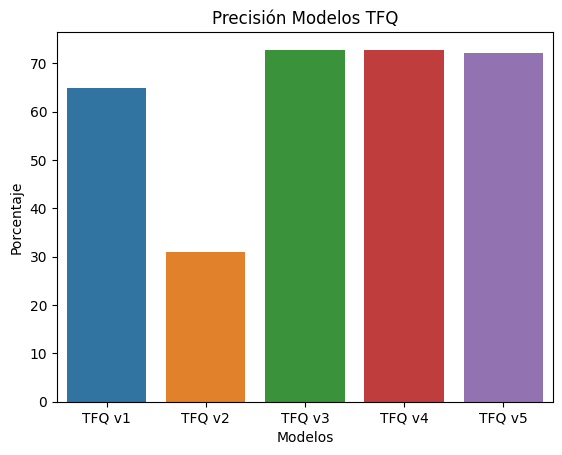

In [82]:
grafica_precision_tfq = seaborn.barplot(x=["TFQ v1","TFQ v2","TFQ v3","TFQ v4","TFQ v5"],
                                        y=[test_acc_v1*100,test_acc_v2*100,test_acc_v3*100,test_acc_v4*100,test_acc*100])
grafica_precision_tfq.set_title("Precisión Modelos TFQ")
grafica_precision_tfq.set_xlabel("Modelos")
grafica_precision_tfq.set_ylabel("Porcentaje")
grafica_precision_tfq.figure.savefig("Precision_modelos_tfq.png", dpi=400)

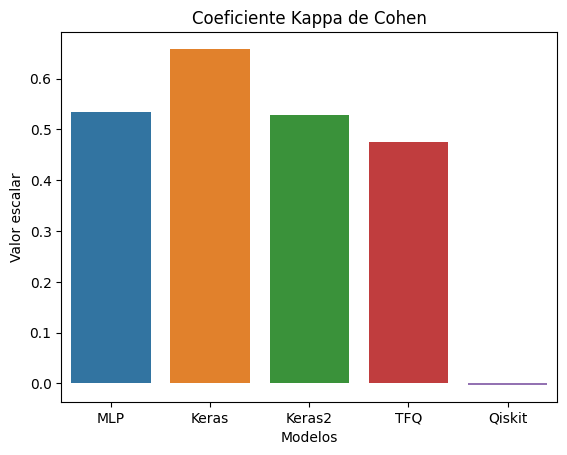

In [130]:
kappa_values = [resultados_mlp[7], kappa_keras, kappa_keras2, kappa_tfq, kappa_q]
model_names = ["MLP","Keras","Keras2","TFQ","Qiskit"]
grafica_kappa = seaborn.barplot(x=model_names, y=kappa_values)
grafica_kappa.set_title("Coeficiente Kappa de Cohen Global")
grafica_kappa.set_xlabel("Modelos")
grafica_kappa.set_ylabel("Valor escalar")
grafica_kappa.figure.savefig("kappa_modelos.png", dpi=400)

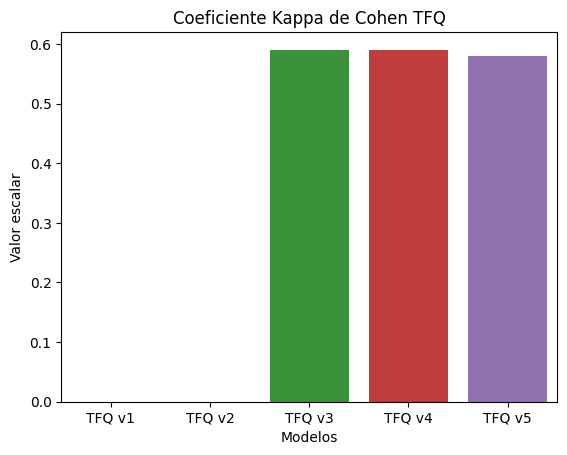

In [84]:
kappa_values_tfq = [kappa_tfq_v1, kappa_tfq_v2, kappa_tfq_v3, kappa_tfq_v4, kappa_tfq]
model_names_tfq = ["TFQ v1","TFQ v2","TFQ v3","TFQ v4","TFQ v5"]
grafica_kappa_tfq = seaborn.barplot(x=model_names_tfq, y=kappa_values_tfq)
grafica_kappa_tfq.set_title("Coeficiente Kappa de Cohen TFQ")
grafica_kappa_tfq.set_xlabel("Modelos")
grafica_kappa_tfq.set_ylabel("Valor escalar")
grafica_kappa_tfq.figure.savefig("kappa_modelos_tfq.png", dpi=400)

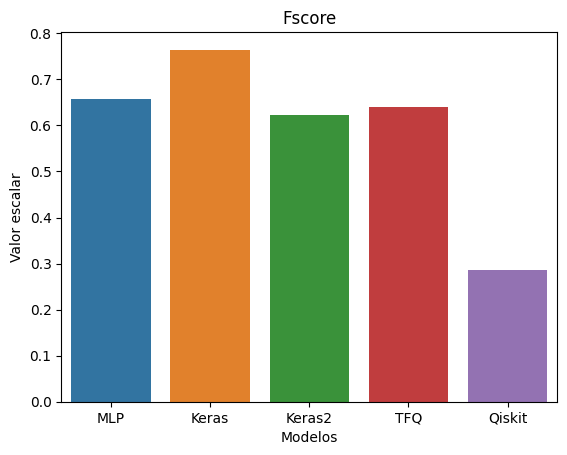

In [131]:
fscore_values = [resultados_mlp[6], f_score_keras, f_score_keras2, f_score_tfq, f1_q]
model_names = ["MLP","Keras","Keras2","TFQ","Qiskit"]
grafica_fscore = seaborn.barplot(x=model_names, y=fscore_values)
grafica_fscore.set_title("Fscore Global")
grafica_fscore.set_xlabel("Modelos")
grafica_fscore.set_ylabel("Valor escalar")
grafica_fscore.figure.savefig("fscore_modelos.png", dpi=400)

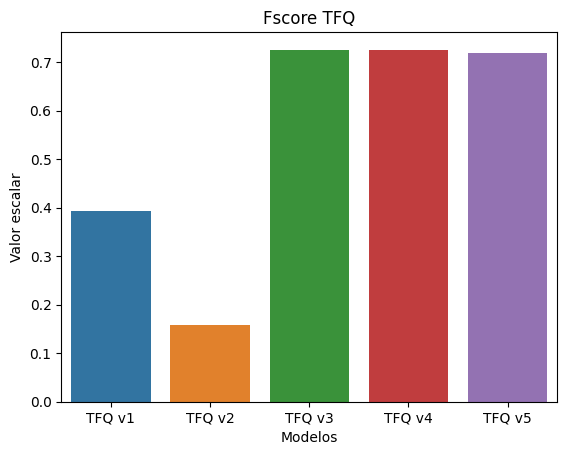

In [86]:
fscore_values_tfq = [f_score_tfq_v1, f_score_tfq_v2, f_score_tfq_v3, f_score_tfq_v4, f_score_tfq]
model_names_tfq = ["TFQ v1","TFQ v2","TFQ v3","TFQ v4","TFQ v5"]
grafica_fscore_tfq = seaborn.barplot(x=model_names_tfq, y=fscore_values_tfq)
grafica_fscore_tfq.set_title("Fscore TFQ")
grafica_fscore_tfq.set_xlabel("Modelos")
grafica_fscore_tfq.set_ylabel("Valor escalar")
grafica_fscore_tfq.figure.savefig("fscore_modelos_tfq.png", dpi=400)

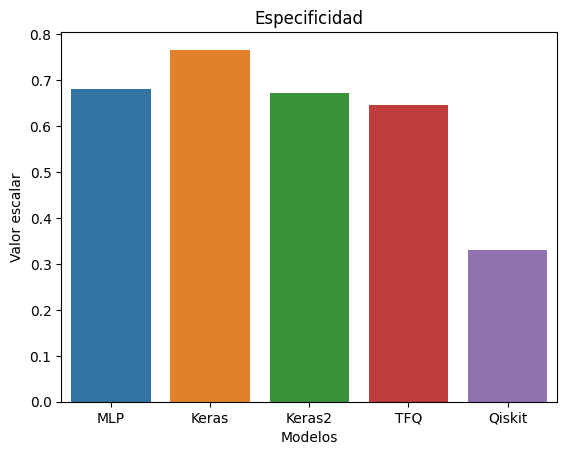

In [132]:
specificity_values = [resultados_mlp[8], avg_specificity_keras,avg_specificity_keras2, avg_specificity_tfq, avg_specificity_q]
model_names = ["MLP","Keras","Keras2","TFQ","Qiskit"]
grafica_specificity = seaborn.barplot(x=model_names, y=specificity_values)
grafica_specificity.set_title("Especificidad Global")
grafica_specificity.set_xlabel("Modelos")
grafica_specificity.set_ylabel("Valor escalar")
grafica_specificity.figure.savefig("specificity_modelos.png", dpi=400)

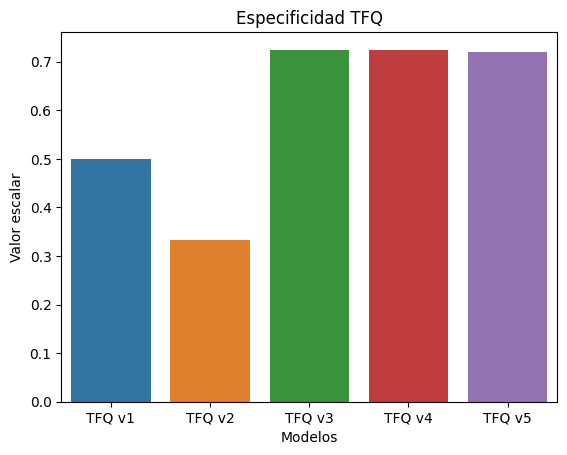

In [88]:
specificity_values_tfq = [avg_specificity_tfq_v1, avg_specificity_tfq_v2,avg_specificity_tfq_v3, avg_specificity_tfq_v4,avg_specificity_tfq]
model_names_tfq = ["TFQ v1","TFQ v2","TFQ v3","TFQ v4","TFQ v5"]
grafica_specificity_tfq = seaborn.barplot(x=model_names_tfq, y=specificity_values_tfq)
grafica_specificity_tfq.set_title("Especificidad TFQ")
grafica_specificity_tfq.set_xlabel("Modelos")
grafica_specificity_tfq.set_ylabel("Valor escalar")
grafica_specificity_tfq.figure.savefig("specificity_modelos_tfq.png", dpi=400)

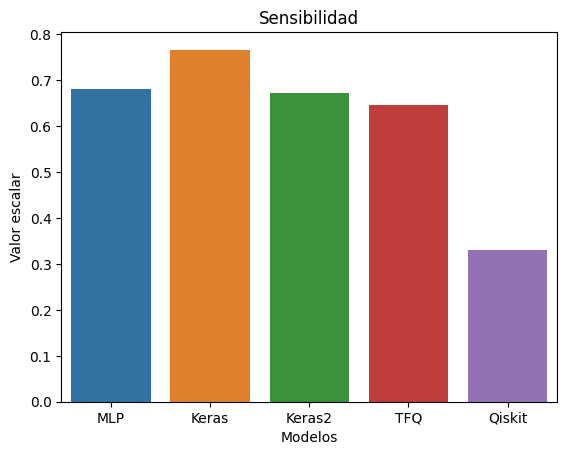

In [133]:
sensitivity_values = [resultados_mlp[5], sensitivity_keras,sensitivity_keras2, sensitivity_tfq, sensitivity_q]
model_names = ["MLP","Keras","Keras2","TFQ","Qiskit"]
grafica_sensitivity= seaborn.barplot(x=model_names, y=sensitivity_values)
grafica_sensitivity.set_title("Sensibilidad Global")
grafica_sensitivity.set_xlabel("Modelos")
grafica_sensitivity.set_ylabel("Valor escalar")
grafica_sensitivity.figure.savefig("sensitivity_modelos.png", dpi=400)

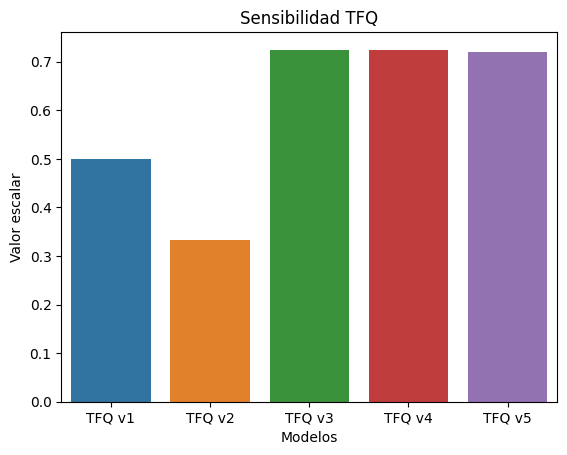

In [90]:
sensitivity_values_tfq = [sensitivity_tfq_v1, sensitivity_tfq_v2,sensitivity_tfq_v3,sensitivity_tfq_v4, sensitivity_tfq]
model_names_tfq = ["TFQ v1","TFQ v2","TFQ v3","TFQ v4","TFQ v5"]
grafica_sensitivity_tfq= seaborn.barplot(x=model_names_tfq, y=sensitivity_values_tfq)
grafica_sensitivity_tfq.set_title("Sensibilidad TFQ")
grafica_sensitivity_tfq.set_xlabel("Modelos")
grafica_sensitivity_tfq.set_ylabel("Valor escalar")
grafica_sensitivity_tfq.figure.savefig("sensitivity_modelos_tfq.png", dpi=400)

## USOS CPU Y RAM

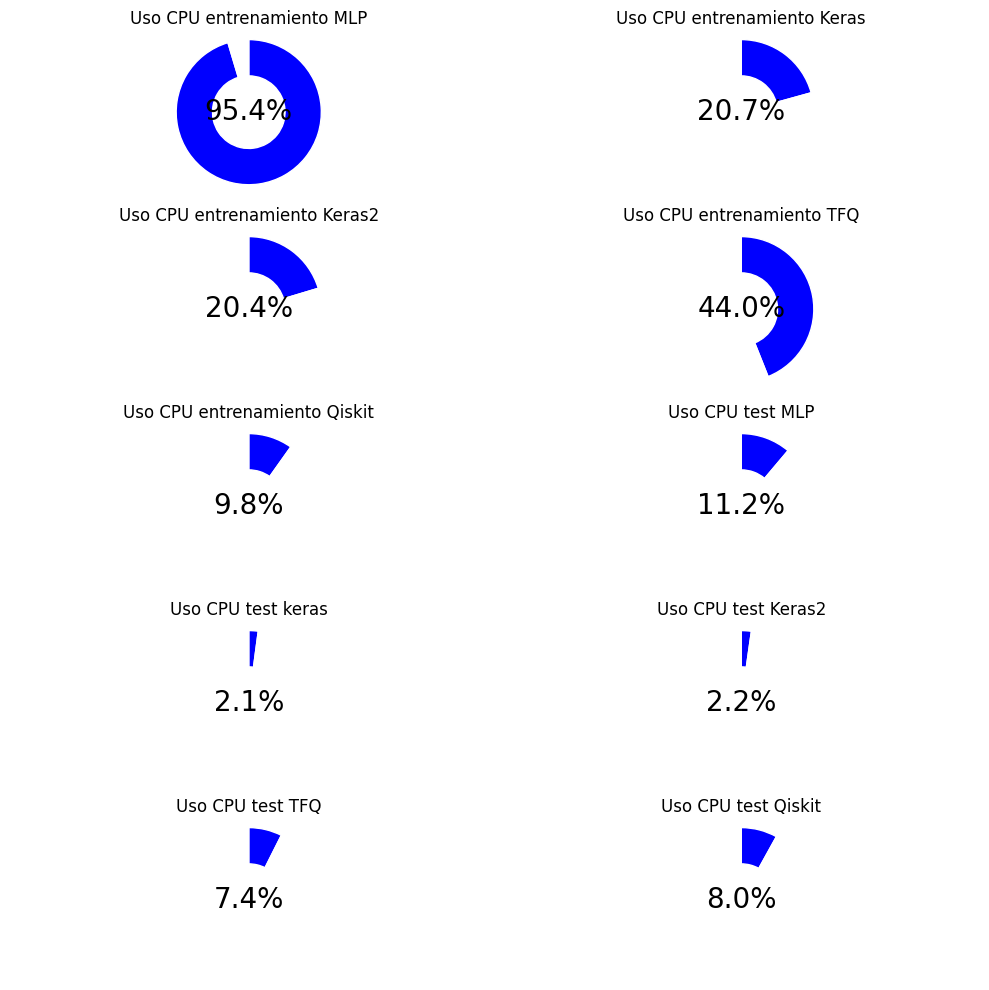

In [99]:
media_uso_cpu_entrenamiento_mlp = np.mean(cpu_percent_list_train_mlp)
media_uso_cpu_entrenamiento_keras = np.mean(cpu_percent_list_train_keras)
media_uso_cpu_entrenamiento_keras2 = np.mean(cpu_percent_list_train_keras2)
media_uso_cpu_entrenamiento_tfq = np.mean(cpu_percent_list_train_tfq)
media_uso_cpu_entrenamiento_q = np.mean(cpu_percent_list_train_q)

media_uso_cpu_test_mlp = np.mean(cpu_percent_list_test_mlp)
media_uso_cpu_test_keras = np.mean(cpu_percent_list_test_keras)
media_uso_cpu_test_keras2 = np.mean(cpu_percent_list_test_keras2)
media_uso_cpu_test_tfq = np.mean(cpu_percent_list_test_tfq)
media_uso_cpu_test_q = np.mean(cpu_percent_list_test_q)

nombres = ['Uso CPU entrenamiento MLP',
           'Uso CPU entrenamiento Keras',
           'Uso CPU entrenamiento Keras2',
           'Uso CPU entrenamiento TFQ',
           'Uso CPU entrenamiento Qiskit',
           'Uso CPU test MLP',
           'Uso CPU test keras',
           'Uso CPU test Keras2',
           'Uso CPU test TFQ',
           'Uso CPU test Qiskit']

porcentajes = [media_uso_cpu_entrenamiento_mlp,
               media_uso_cpu_entrenamiento_keras,
               media_uso_cpu_entrenamiento_keras2,
               media_uso_cpu_entrenamiento_tfq,
               media_uso_cpu_entrenamiento_q,
               media_uso_cpu_test_mlp,
               media_uso_cpu_test_keras,
               media_uso_cpu_test_keras2, 
               media_uso_cpu_test_tfq,
               media_uso_cpu_test_q]


num_plots = len(porcentajes)
num_cols = min(num_plots, 2)
num_rows = (num_plots + num_cols - 1) // num_cols


fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))
for i, (porcentaje, nombre) in enumerate(zip(porcentajes, nombres)):
    row = i // num_cols
    col = i % num_cols
    
    restante = 100 - porcentaje
    datos = [porcentaje, restante]
    axs[row, col].pie(datos, colors=['blue', 'white'], startangle=90, counterclock=False, wedgeprops={'width': 0.5, 'edgecolor': 'white'})
    axs[row, col].text(0, 0, f'{np.around(porcentaje, 1)}%', ha='center', va='center', fontsize=20)
    axs[row, col].axis('equal')
    axs[row, col].set_title(nombre)

fig.tight_layout()
plt.savefig('Porcentajes_uso_cpu.png', dpi=400)
plt.show()

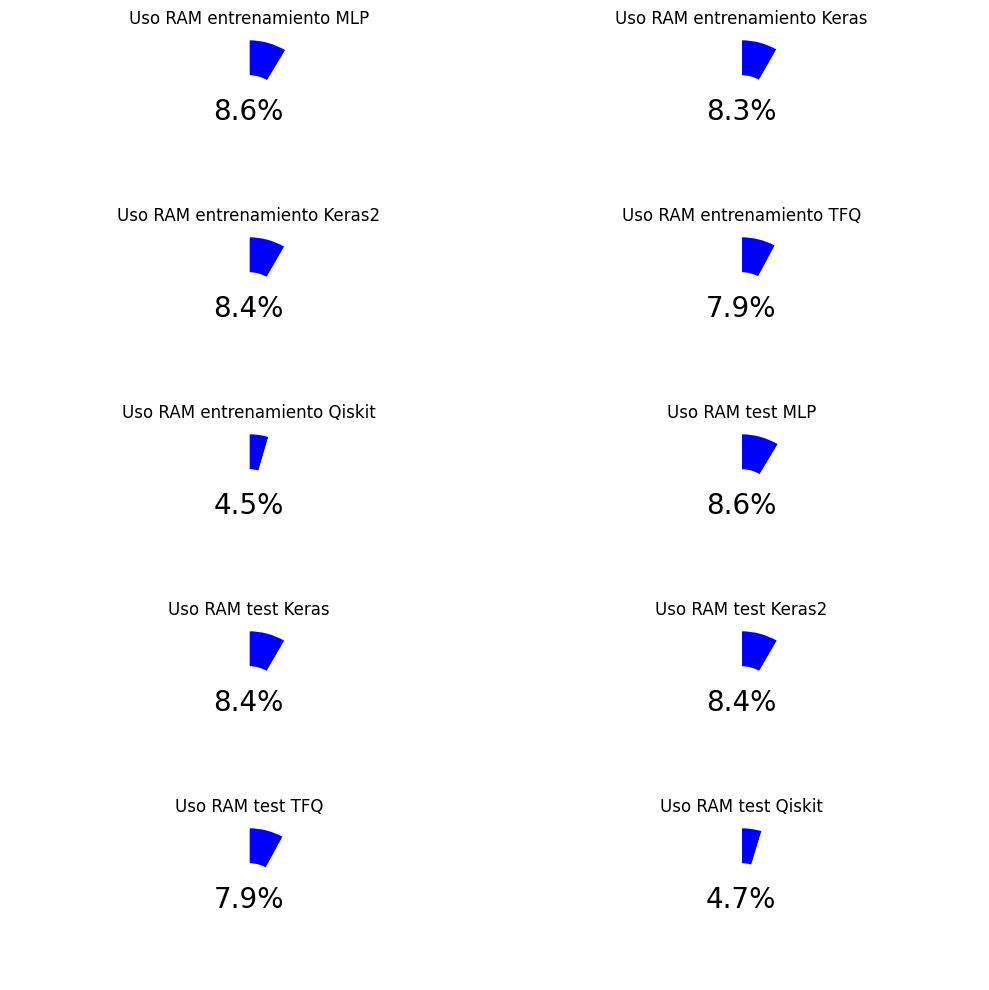

In [100]:
media_uso_ram_entrenamiento_mlp = np.mean(memory_usage_list_train_mlp)
media_uso_ram_entrenamiento_keras = np.mean(memory_usage_list_train_keras)
media_uso_ram_entrenamiento_keras2 = np.mean(memory_usage_list_train_keras2)
media_uso_ram_entrenamiento_tfq = np.mean(memory_usage_list_train_tfq)
media_uso_ram_entrenamiento_q = np.mean(memory_usage_list_train_q)

media_uso_ram_test_mlp = np.mean(memory_usage_list_test_mlp)
media_uso_ram_test_keras = np.mean(memory_usage_list_test_keras)
media_uso_ram_test_keras2 = np.mean(memory_usage_list_test_keras2)
media_uso_ram_test_tfq = np.mean(memory_usage_list_test_tfq)
media_uso_ram_test_q = np.mean(memory_usage_list_test_q)

nombres = ['Uso RAM entrenamiento MLP',
           'Uso RAM entrenamiento Keras',
           'Uso RAM entrenamiento Keras2',
           'Uso RAM entrenamiento TFQ',
           'Uso RAM entrenamiento Qiskit',
           'Uso RAM test MLP',
           'Uso RAM test Keras',
           'Uso RAM test Keras2',
           'Uso RAM test TFQ',
           'Uso RAM test Qiskit']

porcentajes = [media_uso_ram_entrenamiento_mlp, 
               media_uso_ram_entrenamiento_keras,
               media_uso_ram_entrenamiento_keras2,
               media_uso_ram_entrenamiento_tfq,
               media_uso_ram_entrenamiento_q,
               media_uso_ram_test_mlp,
               media_uso_ram_test_keras,
               media_uso_ram_test_keras2, 
               media_uso_ram_test_tfq,
               media_uso_ram_test_q]


num_plots = len(porcentajes)
num_cols = min(num_plots, 2)
num_rows = (num_plots + num_cols - 1) // num_cols


fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))
for i, (porcentaje, nombre) in enumerate(zip(porcentajes, nombres)):
    row = i // num_cols
    col = i % num_cols
    restante = 100 - porcentaje
    datos = [porcentaje, restante]
    axs[row, col].pie(datos, colors=['blue', 'white'], startangle=90, counterclock=False, wedgeprops={'width': 0.5, 'edgecolor': 'white'})
    axs[row, col].text(0, 0, f'{np.around(porcentaje, 1)}%', ha='center', va='center', fontsize=20)
    axs[row, col].axis('equal')

    axs[row, col].set_title(nombre)


fig.tight_layout()
plt.savefig('Porcentajes_uso_ram.png', dpi=400)
plt.show()

## USOS CPU Y RAM SOLO TFQ

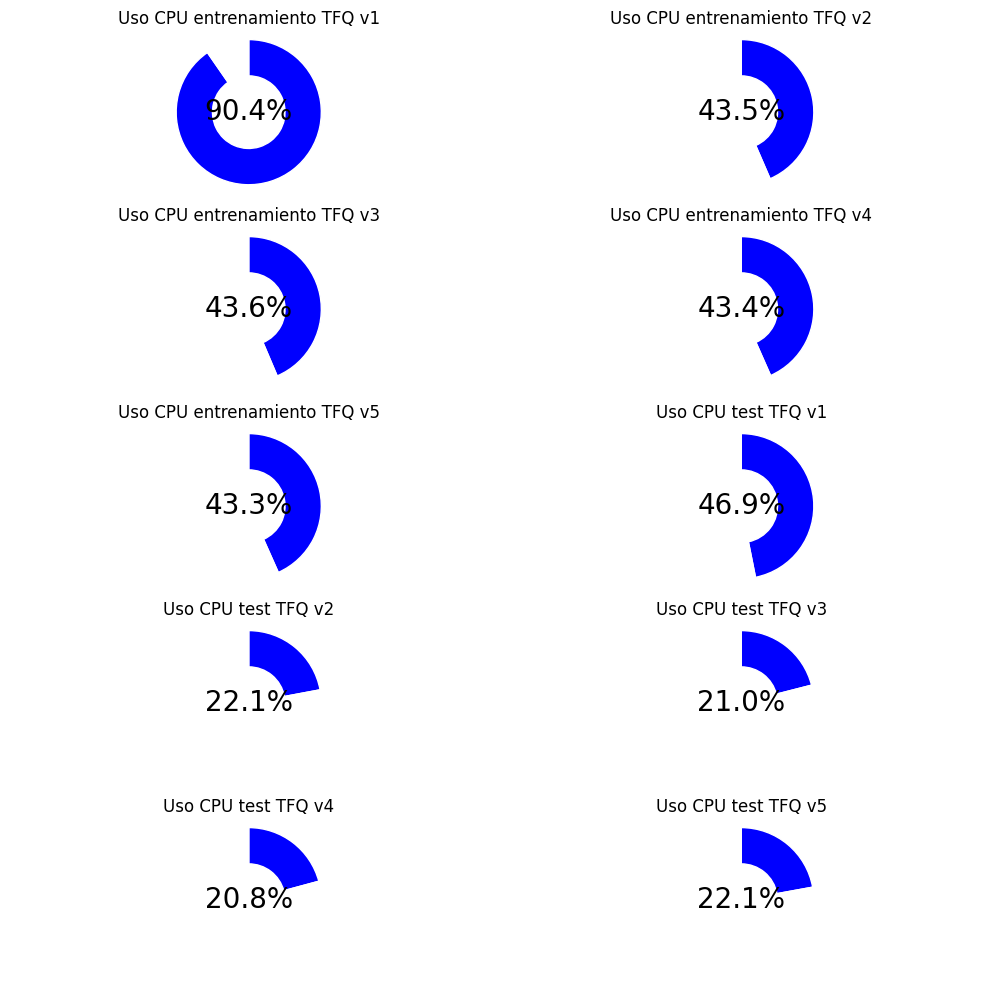

In [76]:
media_uso_cpu_entrenamiento_tfq_1 = np.mean(cpu_percent_list_train_tfq_v1)
media_uso_cpu_entrenamiento_tfq_2 = np.mean(cpu_percent_list_train_tfq_v2)
media_uso_cpu_entrenamiento_tfq_3 = np.mean(cpu_percent_list_train_tfq_v3)
media_uso_cpu_entrenamiento_tfq_4 = np.mean(cpu_percent_list_train_tfq_v4)
media_uso_cpu_entrenamiento_tfq_5 = np.mean(cpu_percent_list_train_tfq_v5)

media_uso_cpu_test_tfq_1 = np.mean(cpu_percent_list_test_tfq_v1)
media_uso_cpu_test_tfq_2 = np.mean(cpu_percent_list_test_tfq_v2)
media_uso_cpu_test_tfq_3 = np.mean(cpu_percent_list_test_tfq_v3)
media_uso_cpu_test_tfq_4 = np.mean(cpu_percent_list_test_tfq_v4)
media_uso_cpu_test_tfq_5 = np.mean(cpu_percent_list_test_tfq_v5)

nombres = ['Uso CPU entrenamiento TFQ v1',
           'Uso CPU entrenamiento TFQ v2',
           'Uso CPU entrenamiento TFQ v3',
           'Uso CPU entrenamiento TFQ v4',
           'Uso CPU entrenamiento TFQ v5',
          'Uso CPU test TFQ v1',
           'Uso CPU test TFQ v2',
           'Uso CPU test TFQ v3',
           'Uso CPU test TFQ v4',
           'Uso CPU test TFQ v5']

porcentajes = [media_uso_cpu_entrenamiento_tfq_1,
               media_uso_cpu_entrenamiento_tfq_2,
               media_uso_cpu_entrenamiento_tfq_3,
               media_uso_cpu_entrenamiento_tfq_4,
               media_uso_cpu_entrenamiento_tfq_5,
               media_uso_cpu_test_tfq_1,
               media_uso_cpu_test_tfq_2,
               media_uso_cpu_test_tfq_3, 
               media_uso_cpu_test_tfq_4,
               media_uso_cpu_test_tfq_5]


num_plots = len(porcentajes)
num_cols = min(num_plots, 2)
num_rows = (num_plots + num_cols - 1) // num_cols


fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))
for i, (porcentaje, nombre) in enumerate(zip(porcentajes, nombres)):
    row = i // num_cols
    col = i % num_cols
    
    restante = 100 - porcentaje
    datos = [porcentaje, restante]
    axs[row, col].pie(datos, colors=['blue', 'white'], startangle=90, counterclock=False, wedgeprops={'width': 0.5, 'edgecolor': 'white'})
    axs[row, col].text(0, 0, f'{np.around(porcentaje, 1)}%', ha='center', va='center', fontsize=20)
    axs[row, col].axis('equal')
    axs[row, col].set_title(nombre)

fig.tight_layout()
plt.savefig('Porcentajes_uso_cpu_modelos_tfq.png', dpi=400)
plt.show()

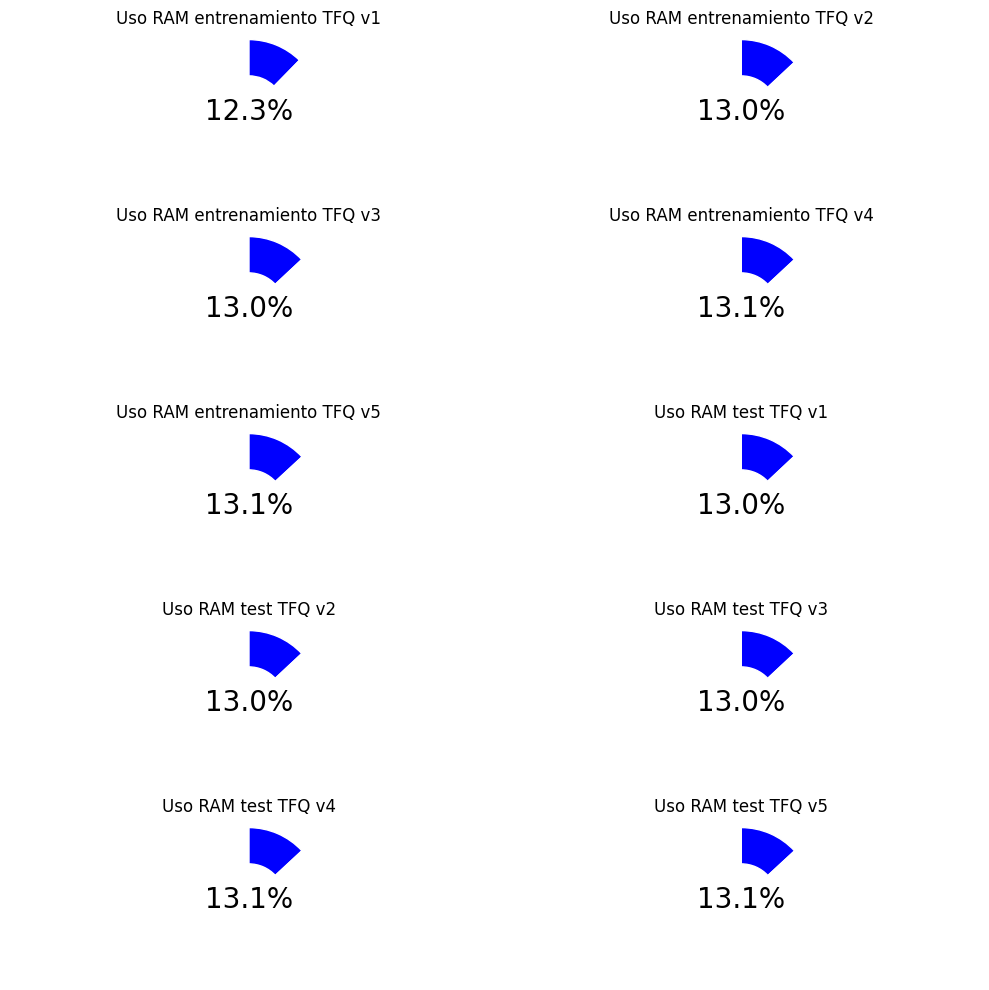

In [77]:
media_uso_ram_entrenamiento_tfq_1 = np.mean(memory_usage_list_train_tfq_v1)
media_uso_ram_entrenamiento_tfq_2= np.mean(memory_usage_list_train_tfq_v2)
media_uso_ram_entrenamiento_tfq_3 = np.mean(memory_usage_list_train_tfq_v3)
media_uso_ram_entrenamiento_tfq_4 = np.mean(memory_usage_list_train_tfq_v4)
media_uso_ram_entrenamiento_tfq_5 = np.mean(memory_usage_list_train_tfq_v5)

media_uso_ram_test_tfq_1 = np.mean(memory_usage_list_test_tfq_v1)
media_uso_ram_test_tfq_2 = np.mean(memory_usage_list_test_tfq_v2)
media_uso_ram_test_tfq_3 = np.mean(memory_usage_list_test_tfq_v3)
media_uso_ram_test_tfq_4 = np.mean(memory_usage_list_test_tfq_v4)
media_uso_ram_test_tfq_5 = np.mean(memory_usage_list_test_tfq_v5)

nombres = ['Uso RAM entrenamiento TFQ v1',
           'Uso RAM entrenamiento TFQ v2',
           'Uso RAM entrenamiento TFQ v3',
           'Uso RAM entrenamiento TFQ v4',
           'Uso RAM entrenamiento TFQ v5',
           'Uso RAM test TFQ v1',
           'Uso RAM test TFQ v2',
           'Uso RAM test TFQ v3',
           'Uso RAM test TFQ v4',
           'Uso RAM test TFQ v5']

porcentajes = [media_uso_ram_entrenamiento_tfq_1, 
               media_uso_ram_entrenamiento_tfq_2,
               media_uso_ram_entrenamiento_tfq_3,
               media_uso_ram_entrenamiento_tfq_4,
               media_uso_ram_entrenamiento_tfq_5,
               media_uso_ram_test_tfq_1,
               media_uso_ram_test_tfq_2,
               media_uso_ram_test_tfq_3, 
               media_uso_ram_test_tfq_4,
               media_uso_ram_test_tfq_5]


num_plots = len(porcentajes)
num_cols = min(num_plots, 2)
num_rows = (num_plots + num_cols - 1) // num_cols


fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))
for i, (porcentaje, nombre) in enumerate(zip(porcentajes, nombres)):
    row = i // num_cols
    col = i % num_cols
    restante = 100 - porcentaje
    datos = [porcentaje, restante]
    axs[row, col].pie(datos, colors=['blue', 'white'], startangle=90, counterclock=False, wedgeprops={'width': 0.5, 'edgecolor': 'white'})
    axs[row, col].text(0, 0, f'{np.around(porcentaje, 1)}%', ha='center', va='center', fontsize=20)
    axs[row, col].axis('equal')

    axs[row, col].set_title(nombre)


fig.tight_layout()
plt.savefig('Porcentajes_uso_ram_modelos_tfq.png', dpi=400)
plt.show()

## Tiempos

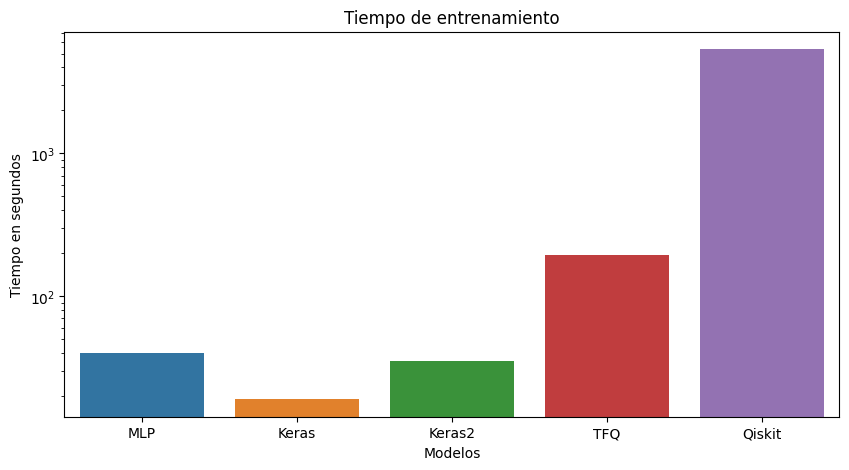

In [118]:
modelos = ["MLP", "Keras", "Keras2", "TFQ", "Qiskit"]
counts = [resultados_mlp[1], endTrainingTime_keras, endTrainingTime_keras2, endTrainingTime_tfq, endTrainingTime_q]

fig = plt.figure(dpi=100, figsize=(10, 5))
ax = fig.gca()
seaborn.barplot(x=modelos, y=counts, ax=ax, orient="v")
ax.set_ylabel("Tiempo en segundos")
ax.set_xlabel("Modelos")
ax.set_title(f"Tiempo de entrenamiento Global")
ax.set_yscale("log")
plt.savefig('Tiempo_entrenamiento.png', dpi=400)
plt.show()

In [102]:
print("Tiempo entrenamiento MLP: ", resultados_mlp[1],"segundos")
print("Tiempo entrenamiento Keras: ", endTrainingTime_keras, "segundos")
print("Tiempo entrenamiento Keras2: ", endTrainingTime_keras2, "segundos")
print("Tiempo entrenamiento TFQ: ", endTrainingTime_tfq, "segundos")
print("Tiempo entrenamiento Qiskit: ", endTrainingTime_q, "segundos")

Tiempo entrenamiento MLP:  40.057185649871826 segundos
Tiempo entrenamiento Keras:  19.02955675125122 segundos
Tiempo entrenamiento Keras2:  35.05403780937195 segundos
Tiempo entrenamiento TFQ:  195.3130841255188 segundos
Tiempo entrenamiento Qiskit:  5364.013592243195 segundos


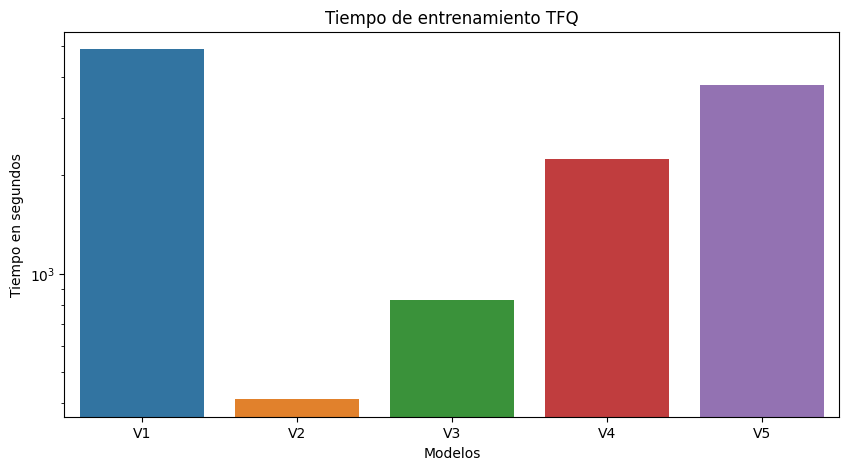

In [92]:
modelos = ["V1","V2","V3","V4","V5"]
counts = [endTrainingTime_tfq_v1,endTrainingTime_tfq_v2,endTrainingTime_tfq_v3,endTrainingTime_tfq_v4,endTrainingTime_tfq_v5]
fig = plt.figure(dpi=100, figsize=(10,5))
ax = fig.gca()
seaborn.barplot(x=modelos, y=counts, ax=ax, orient="v")
ax.set_ylabel("Tiempo en segundos")
ax.set_xlabel("Modelos")
ax.set_title(f"Tiempo de entrenamiento TFQ")
ax.set_yscale("log")
plt.savefig('Tiempo_entrenamiento_modelos_tfq.png', dpi=400)
plt.show()

In [71]:
print("Tiempo testeo TFQ v1: ", endTrainingTime_tfq_v1,"segundos")
print("Tiempo testeo TFQ v2: ", endTrainingTime_tfq_v2, "segundos")
print("Tiempo testeo TFQ v3: ", endTrainingTime_tfq_v3, "segundos")
print("Tiempo testeo TFQ v4: ", endTrainingTime_tfq_v4, "segundos")
print("Tiempo testeo TFQ v5: ", endTrainingTime_tfq_v5, "segundos")

Tiempo testeo TFQ v1:  4879.635807514191 segundos
Tiempo testeo TFQ v2:  411.6541121006012 segundos
Tiempo testeo TFQ v3:  832.3117244243622 segundos
Tiempo testeo TFQ v4:  2254.5680725574493 segundos
Tiempo testeo TFQ v5:  3780.081883907318 segundos


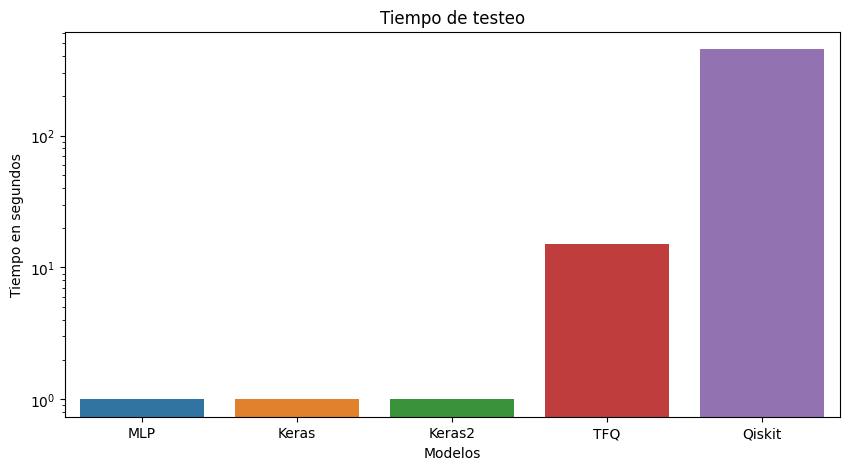

In [119]:
modelos = ["MLP", "Keras","Keras2","TFQ","Qiskit"]
counts = [resultados_mlp[2],endTestingTime_keras,endTestingTime_keras2,endTestingTime_tfq,endTestingTime_q]
fig = plt.figure(dpi=100, figsize=(10,5))
ax = fig.gca()
seaborn.barplot(x=modelos, y=counts, ax=ax, orient="v")
ax.set_ylabel("Tiempo en segundos")
ax.set_xlabel("Modelos")
ax.set_title(f"Tiempo de testeo Global")
ax.set_yscale("log")
plt.savefig('Tiempo_testeo.png', dpi=400)
plt.show()

In [104]:
print("Tiempo testeo MLP: ", resultados_mlp[2],"segundos")
print("Tiempo testeo Keras: ", endTestingTime_keras, "segundos")
print("Tiempo testeo Keras2: ", endTestingTime_keras2, "segundos")
print("Tiempo testeo TFQ: ", endTestingTime_tfq, "segundos")
print("Tiempo testeo Qiskit: ", endTestingTime_q, "segundos")

Tiempo testeo MLP:  1.0020241737365723 segundos
Tiempo testeo Keras:  1.003194808959961 segundos
Tiempo testeo Keras2:  1.004643440246582 segundos
Tiempo testeo TFQ:  15.025948286056519 segundos
Tiempo testeo Qiskit:  451.896124124527 segundos


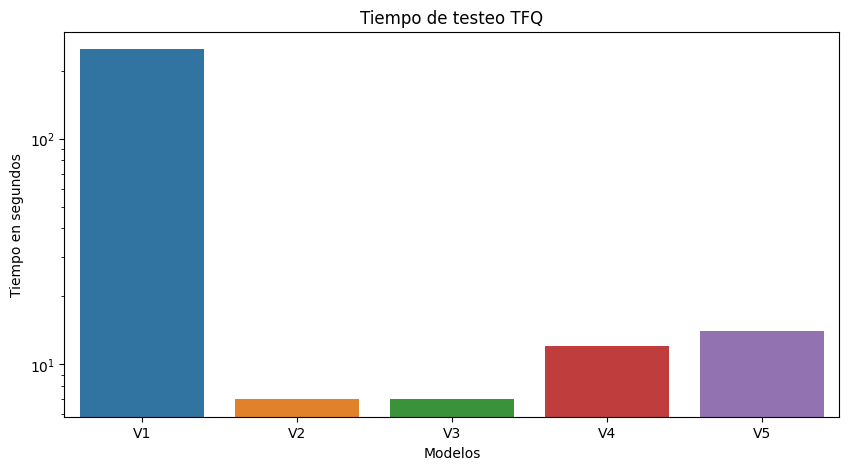

In [93]:
modelos = ["V1", "V2","V3","V4","V5"]
counts = [endTestingTime_tfq_v1,endTestingTime_tfq_v2,endTestingTime_tfq_v3,endTestingTime_tfq_v4,endTestingTime_tfq_v5]
fig = plt.figure(dpi=100, figsize=(10,5))
ax = fig.gca()
seaborn.barplot(x=modelos, y=counts, ax=ax, orient="v")
ax.set_ylabel("Tiempo en segundos")
ax.set_xlabel("Modelos")
ax.set_title(f"Tiempo de testeo TFQ")
ax.set_yscale("log")
plt.savefig('Tiempo_testeo_modelos_tfq.png', dpi=400)
plt.show()

In [64]:
print("Tiempo testeo TFQ v1: ", endTestingTime_tfq_v1,"segundos")
print("Tiempo testeo TFQ v2: ", endTestingTime_tfq_v2, "segundos")
print("Tiempo testeo TFQ v3: ", endTestingTime_tfq_v3, "segundos")
print("Tiempo testeo TFQ v4: ", endTestingTime_tfq_v4, "segundos")
print("Tiempo testeo TFQ v5: ", endTestingTime_tfq_v5, "segundos")

Tiempo testeo TFQ v1:  248.6170620918274 segundos
Tiempo testeo TFQ v2:  7.009839773178101 segundos
Tiempo testeo TFQ v3:  7.013120651245117 segundos
Tiempo testeo TFQ v4:  12.01677680015564 segundos
Tiempo testeo TFQ v5:  14.020703315734863 segundos
